In [94]:
import argparse
import os
import random
import time

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
# import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [95]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-27-104.net.auckland.ac.nz


In [96]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [97]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# probability of augmenting data
aug_p = 0.5

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().mean()
print('Dataset std: ',  gw_std)

gw_scaling_factor = 5
print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

Dataset mean:  -0.04824243411562023
Dataset std:  28.792067898778328
Dataset scaling factor (to match noise in generator):  5


Dataset mean:  -0.046364527
Dataset std:  31.57518
Dataset scaling factor (to match noise in generator):  5
torch.Size([32, 1, 512])


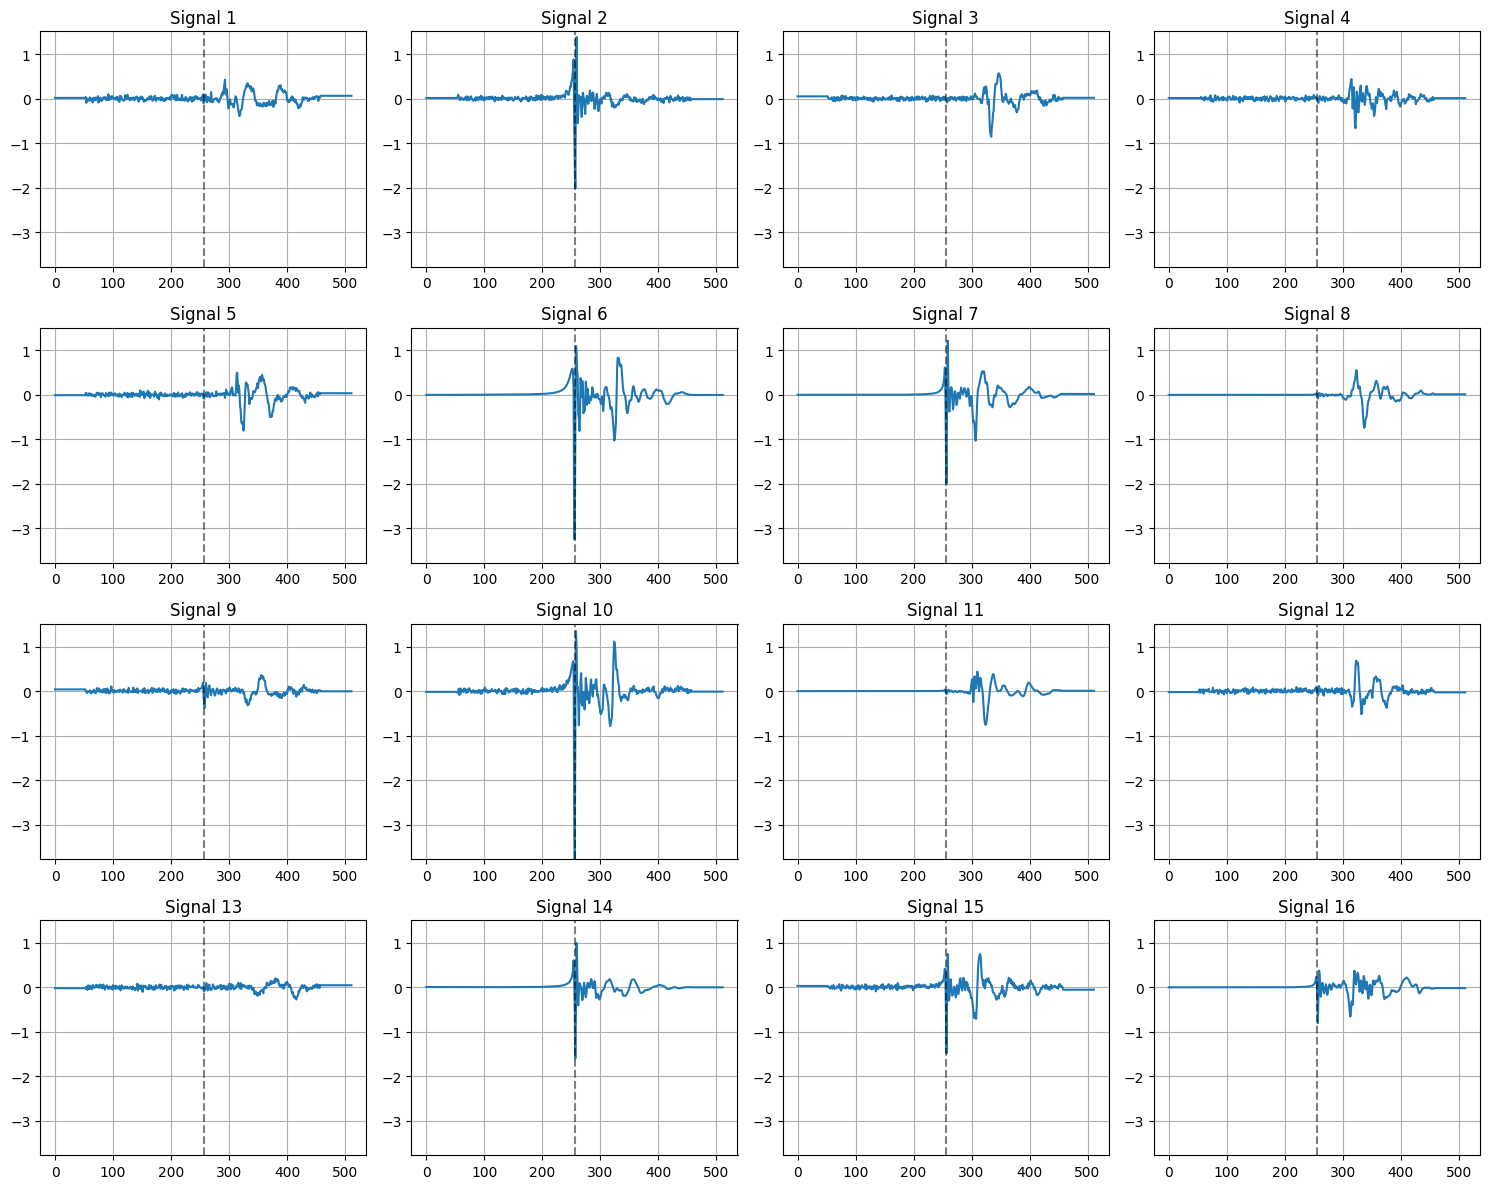

In [149]:
class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')
        self.data = self.data.values

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    # def pad_signals(self):
    #     desired_length = 512
    #     augmented_signals = np.empty((desired_length, self.data.shape[1]), dtype=int)

    #     for i in range(self.data.shape[1]):
    #         signal = self.data[:, i]
    #         signal = signal.reshape(1, -1)

    #         padding_left = (desired_length - len(signal[0])) // 2
    #         padding_right = desired_length - len(signal[0]) - padding_left

    #         signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

    #         augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], signal_padded, axis=1)

    #     self.data = augmented_signals
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scaled_signal = scale_factor * signal

        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203

        # noise = np.random.normal(0, 0.05, signal.shape[1] - noise_start_time)
        # jittered_signal = signal[noise_start_time:] + noise
        noise = np.random.normal(0, 5, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = numpy.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_1 - signal_2)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # don't warp anything before the core-bounce
        warp_start_time = 203
        select_idx = signal
        # make the window 10% of the original data
        window_size = signal.shape[1] / 10

        # Ensure that the range is within bounds
        random_start = np.random.randint(lower_limit, upper_limit - i + 1)
        random_range = np.arange(random_start, random_start + i)
        
        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        augmented_signals = self.data.copy()

        while augmented_signals.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.randint(0, self.data.shape[1])
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.jittering_augmentation(signal_1)

            augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], augmented_signal, axis=1)

        self.data = augmented_signals

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        # distance = 3.086e22
        # signal = signal / distance

        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
common_ylim_signal = dataset.get_common()
# dataset.pad_signals()
dataset.augmentation(6000)
dataset.calc_stats()
# dataset.standardize()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

In [148]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [100]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [101]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [102]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(300, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [103]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [104]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [105]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/20][0/188]	Loss_D: 1.9221	Loss_G: 0.8189	D(x): 0.2876	D(G(z)): 0.3985 / 0.4042
[0/20][50/188]	Loss_D: 1.0047	Loss_G: 2.3254	D(x): 0.1549	D(G(z)): 0.6637 / 0.6835
[0/20][100/188]	Loss_D: 0.8518	Loss_G: 1.8812	D(x): 0.1543	D(G(z)): 0.7452 / 0.6217
[0/20][150/188]	Loss_D: 0.6951	Loss_G: 2.1611	D(x): 0.1815	D(G(z)): 0.6984 / 0.7320


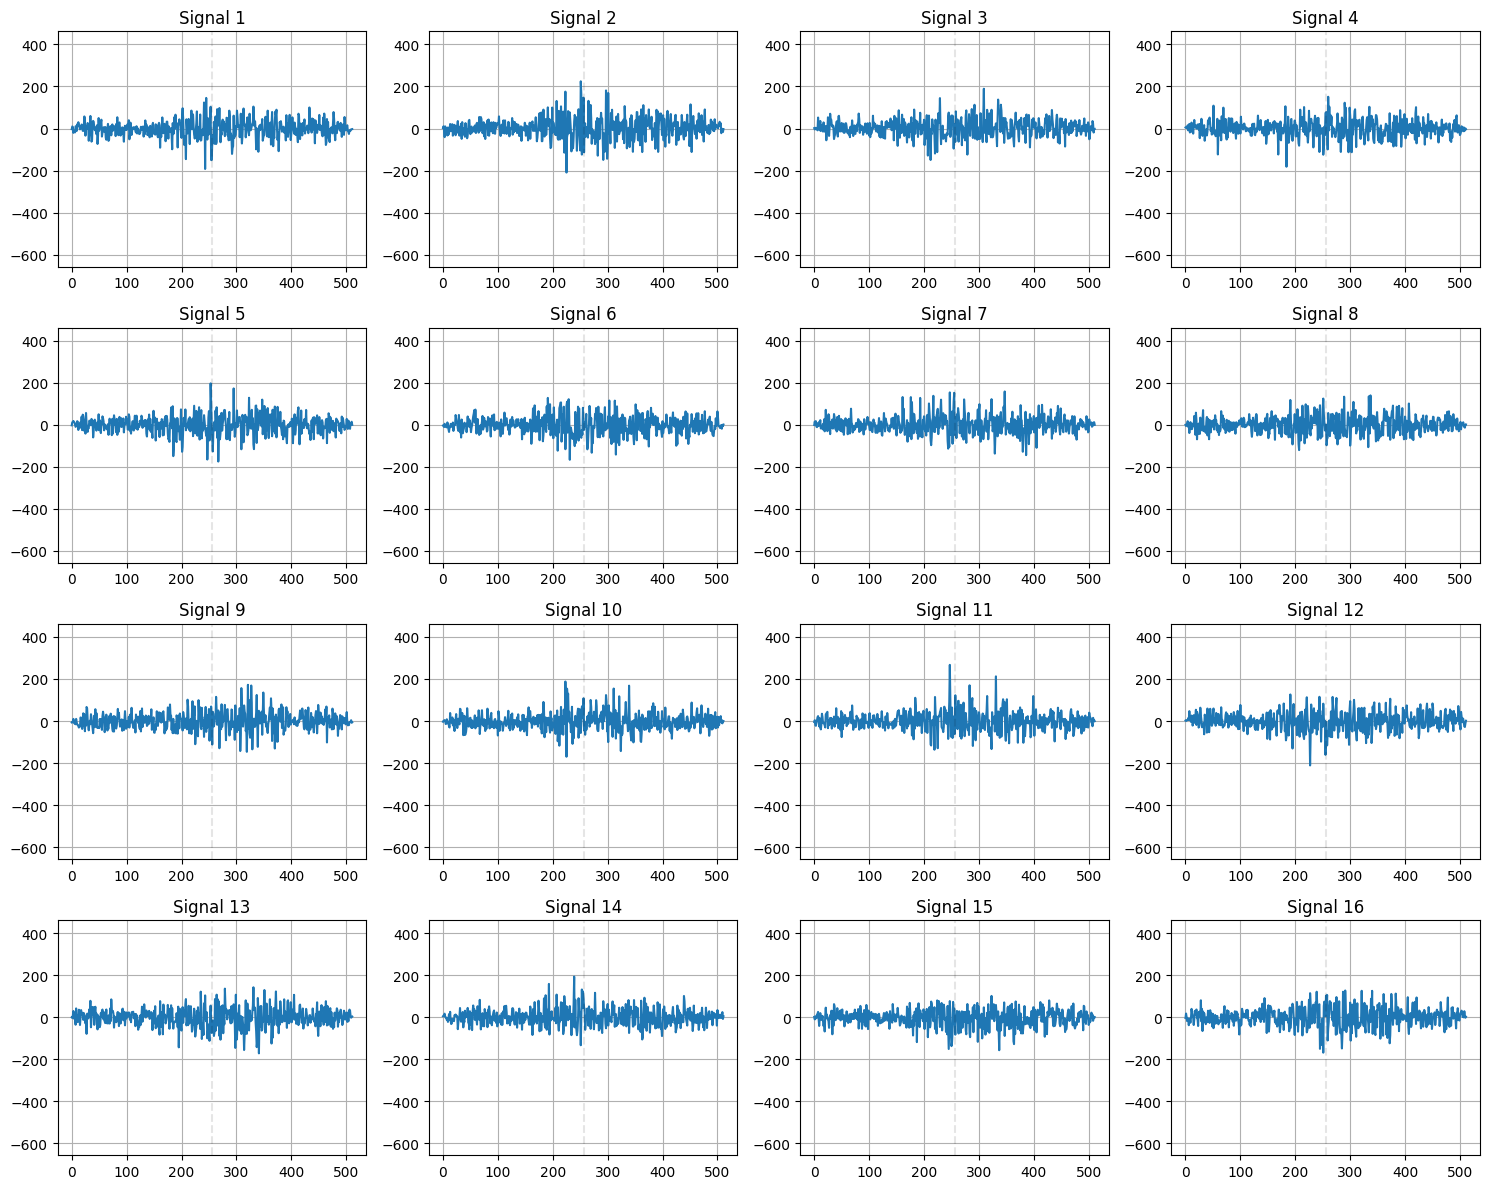

[1/20][0/188]	Loss_D: 0.8326	Loss_G: 2.8728	D(x): 0.1264	D(G(z)): 0.7451 / 0.7807
[1/20][50/188]	Loss_D: 1.0743	Loss_G: 3.1556	D(x): 0.2286	D(G(z)): 0.8064 / 0.7876
[1/20][100/188]	Loss_D: 0.9802	Loss_G: 2.5128	D(x): 0.1548	D(G(z)): 0.7285 / 0.6538
[1/20][150/188]	Loss_D: 0.5767	Loss_G: 2.3182	D(x): 0.1369	D(G(z)): 0.7938 / 0.6869


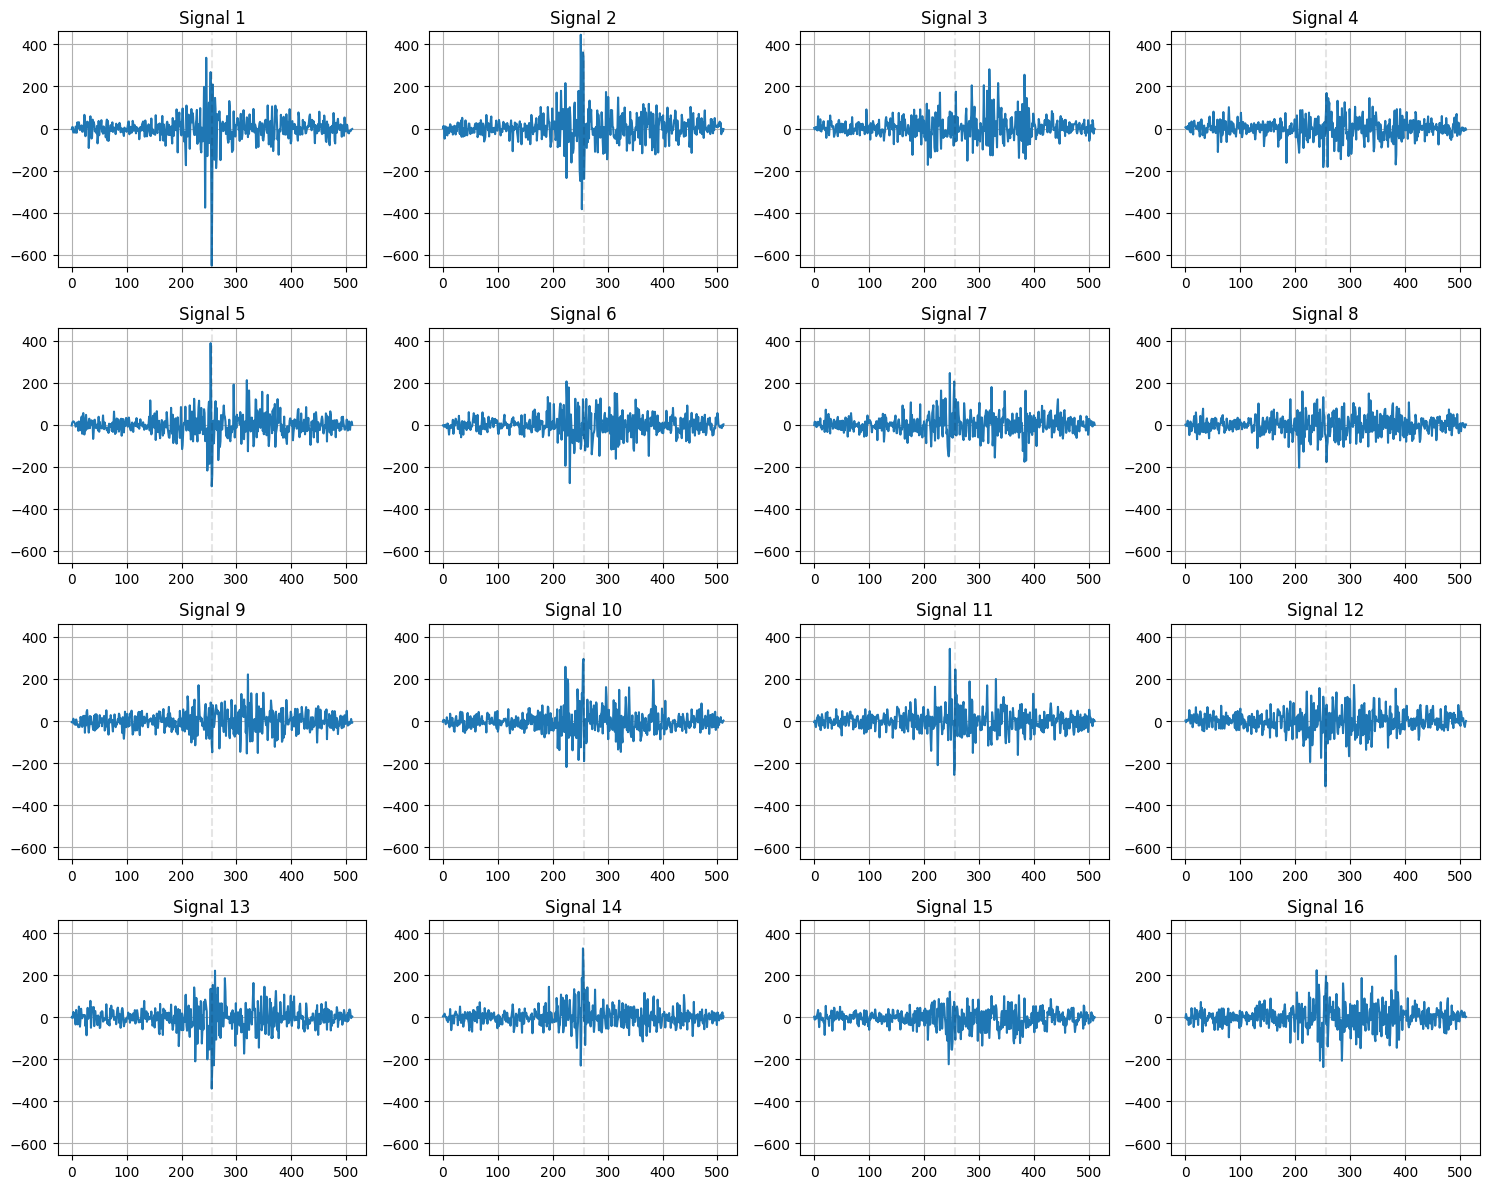

[2/20][0/188]	Loss_D: 0.9303	Loss_G: 3.0268	D(x): 0.1984	D(G(z)): 0.7509 / 0.8064
[2/20][50/188]	Loss_D: 0.8490	Loss_G: 2.9334	D(x): 0.1364	D(G(z)): 0.6895 / 0.7982
[2/20][100/188]	Loss_D: 0.9705	Loss_G: 3.1471	D(x): 0.1617	D(G(z)): 0.7868 / 0.7826
[2/20][150/188]	Loss_D: 1.0682	Loss_G: 2.2301	D(x): 0.2311	D(G(z)): 0.7866 / 0.7107


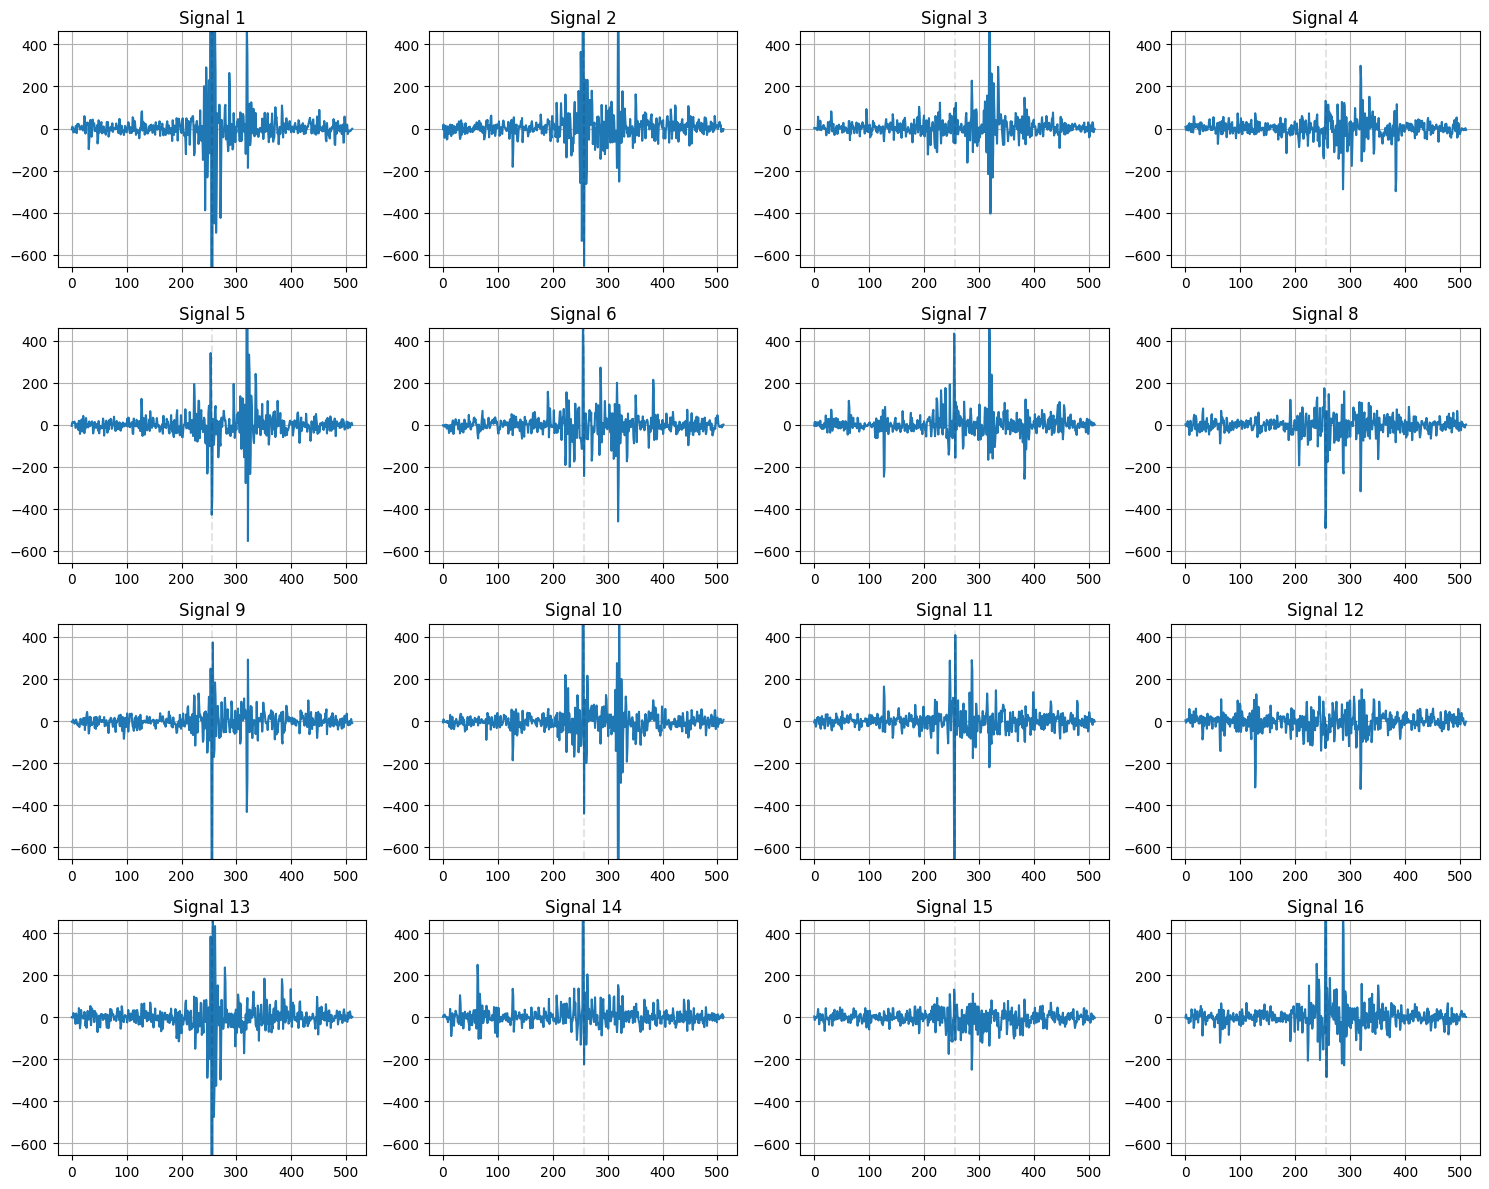

[3/20][0/188]	Loss_D: 0.9657	Loss_G: 1.8143	D(x): 0.1450	D(G(z)): 0.7305 / 0.6997
[3/20][50/188]	Loss_D: 0.8927	Loss_G: 2.3028	D(x): 0.2277	D(G(z)): 0.8012 / 0.7234
[3/20][100/188]	Loss_D: 1.2091	Loss_G: 2.4163	D(x): 0.0988	D(G(z)): 0.7286 / 0.7441
[3/20][150/188]	Loss_D: 1.3058	Loss_G: 2.1853	D(x): 0.1424	D(G(z)): 0.6254 / 0.7491


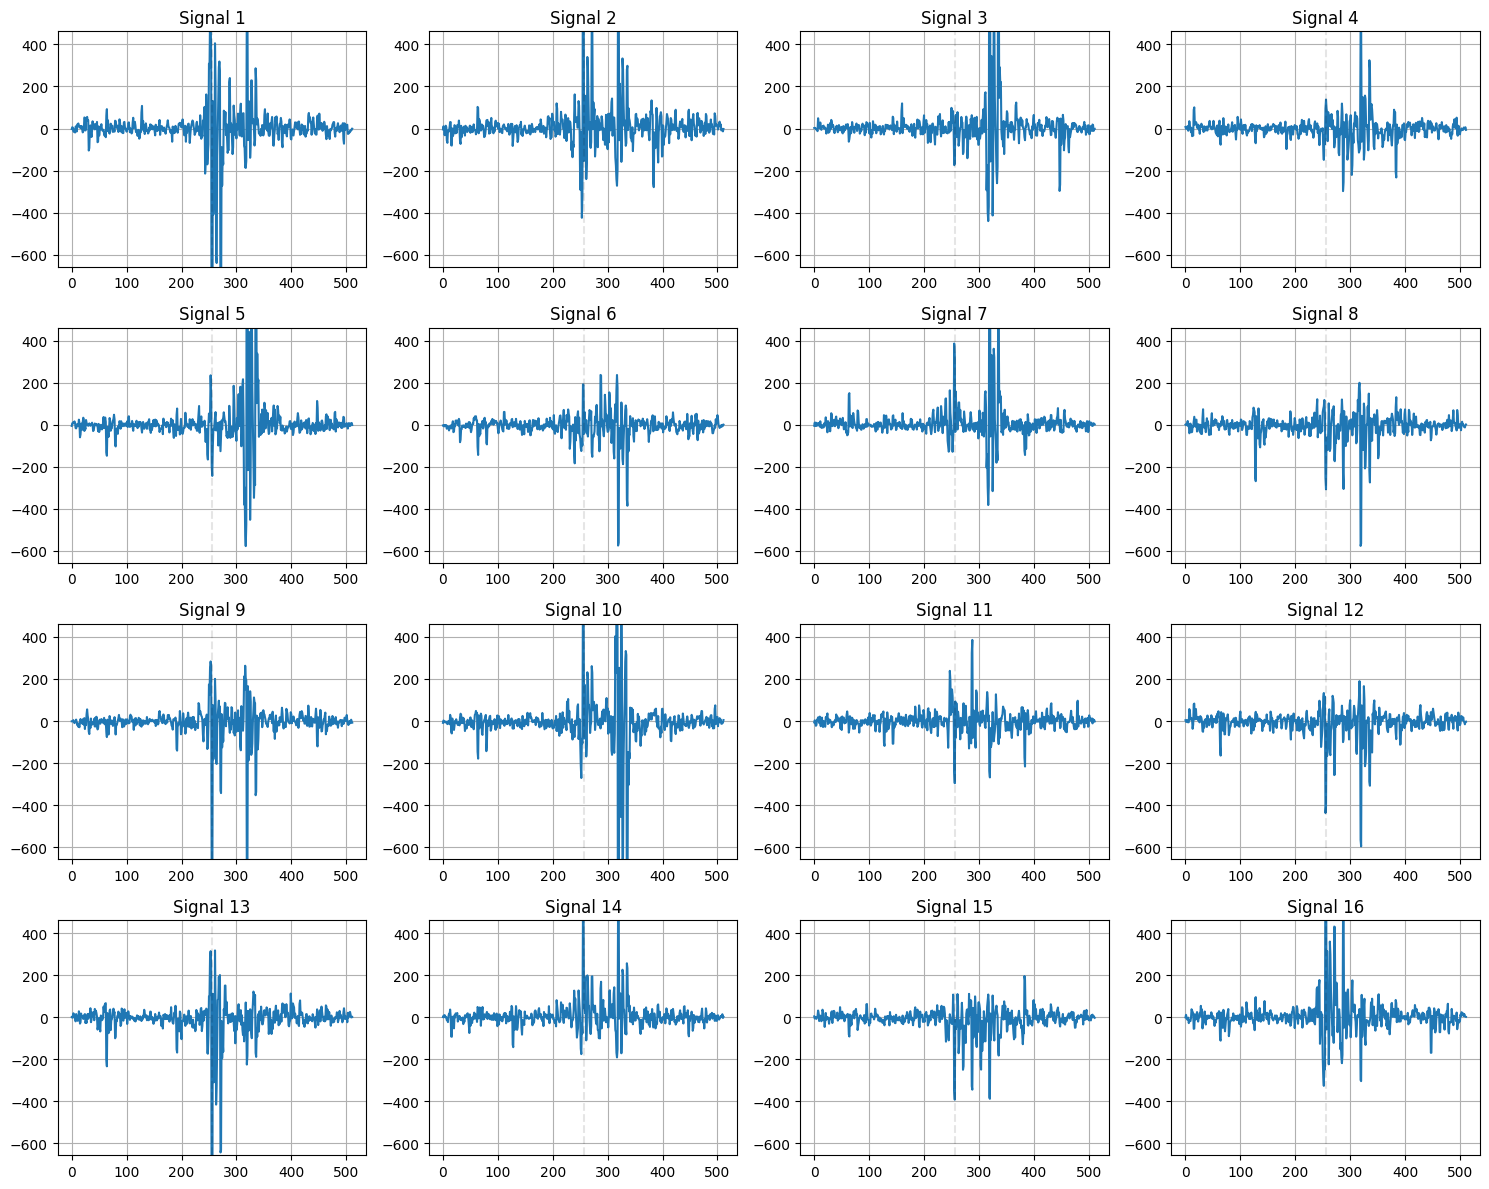

[4/20][0/188]	Loss_D: 0.8088	Loss_G: 2.9838	D(x): 0.2002	D(G(z)): 0.7280 / 0.8021
[4/20][50/188]	Loss_D: 0.7407	Loss_G: 2.4521	D(x): 0.0974	D(G(z)): 0.6787 / 0.7381
[4/20][100/188]	Loss_D: 0.9076	Loss_G: 2.9609	D(x): 0.1668	D(G(z)): 0.7327 / 0.7749
[4/20][150/188]	Loss_D: 0.6674	Loss_G: 2.8154	D(x): 0.1122	D(G(z)): 0.8253 / 0.8340


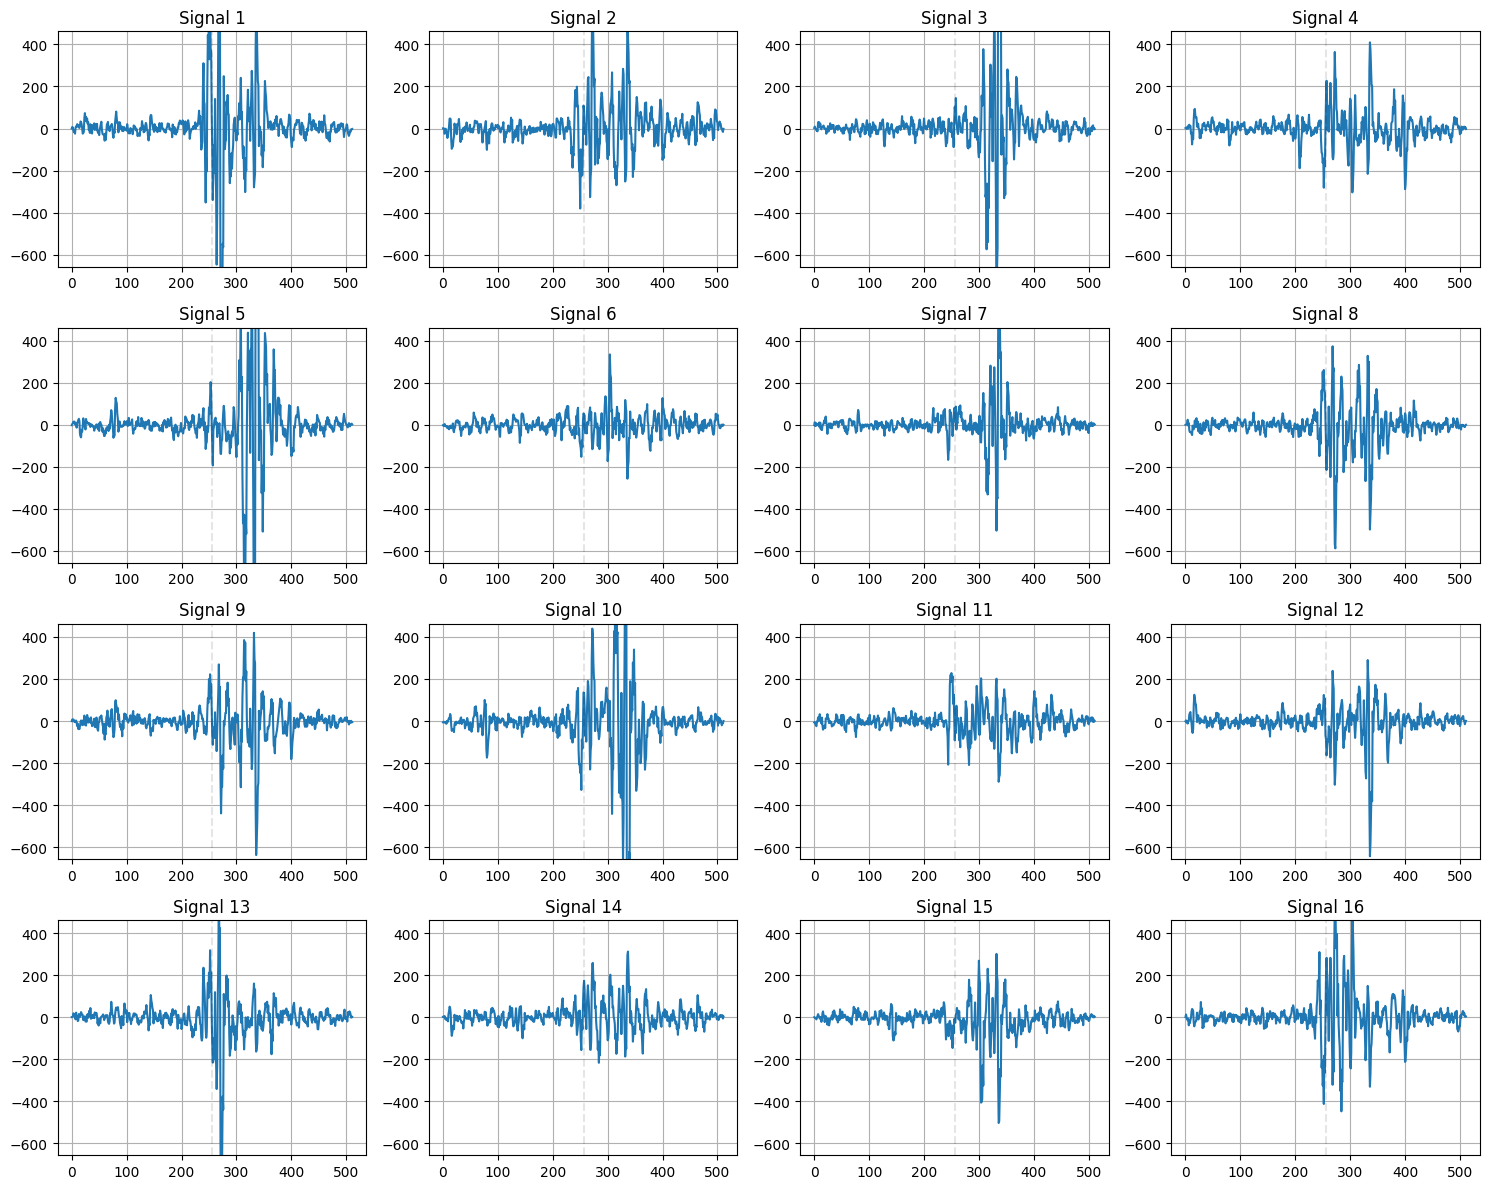

[5/20][0/188]	Loss_D: 1.0894	Loss_G: 2.3393	D(x): 0.1899	D(G(z)): 0.6693 / 0.7473
[5/20][50/188]	Loss_D: 0.8442	Loss_G: 4.0759	D(x): 0.1728	D(G(z)): 0.7475 / 0.8677
[5/20][100/188]	Loss_D: 0.3806	Loss_G: 2.1005	D(x): 0.1045	D(G(z)): 0.8401 / 0.7129
[5/20][150/188]	Loss_D: 0.8989	Loss_G: 2.3511	D(x): 0.2218	D(G(z)): 0.7528 / 0.7145


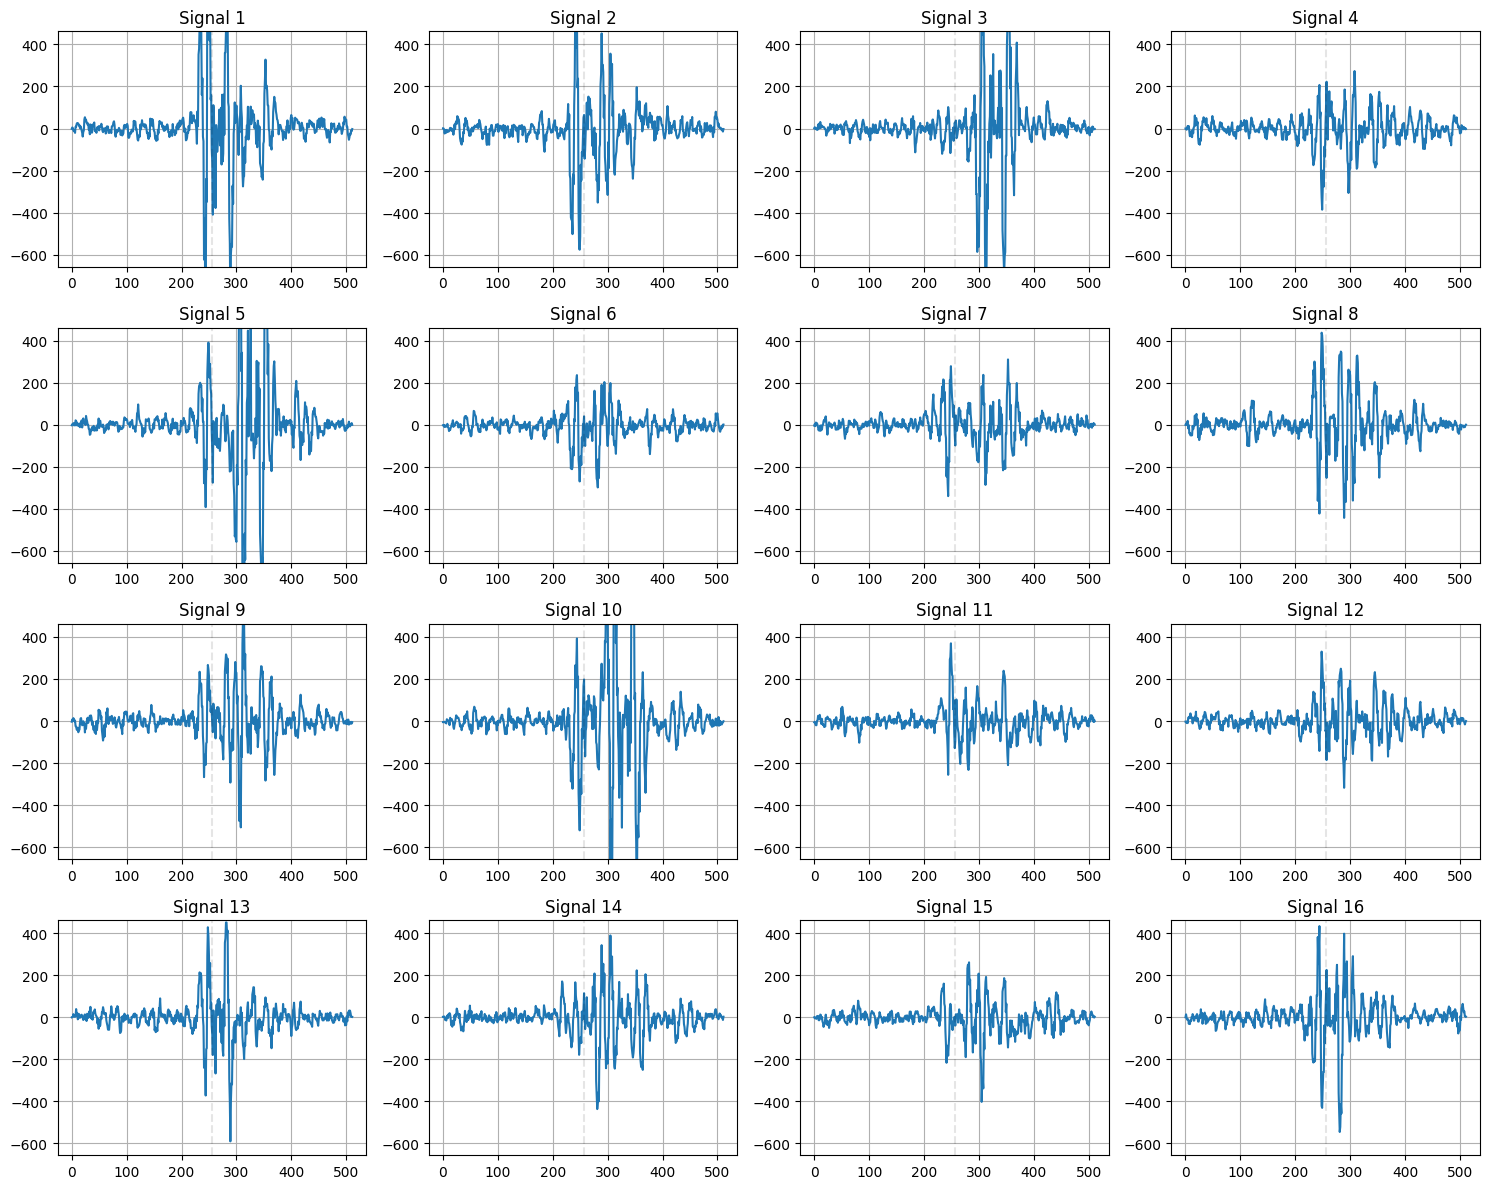

[6/20][0/188]	Loss_D: 1.0346	Loss_G: 2.4823	D(x): 0.1762	D(G(z)): 0.5993 / 0.7883
[6/20][50/188]	Loss_D: 0.8273	Loss_G: 3.6729	D(x): 0.0947	D(G(z)): 0.7455 / 0.8641
[6/20][100/188]	Loss_D: 1.0856	Loss_G: 3.4911	D(x): 0.1784	D(G(z)): 0.7379 / 0.8135
[6/20][150/188]	Loss_D: 0.9317	Loss_G: 2.7287	D(x): 0.2132	D(G(z)): 0.8273 / 0.7943


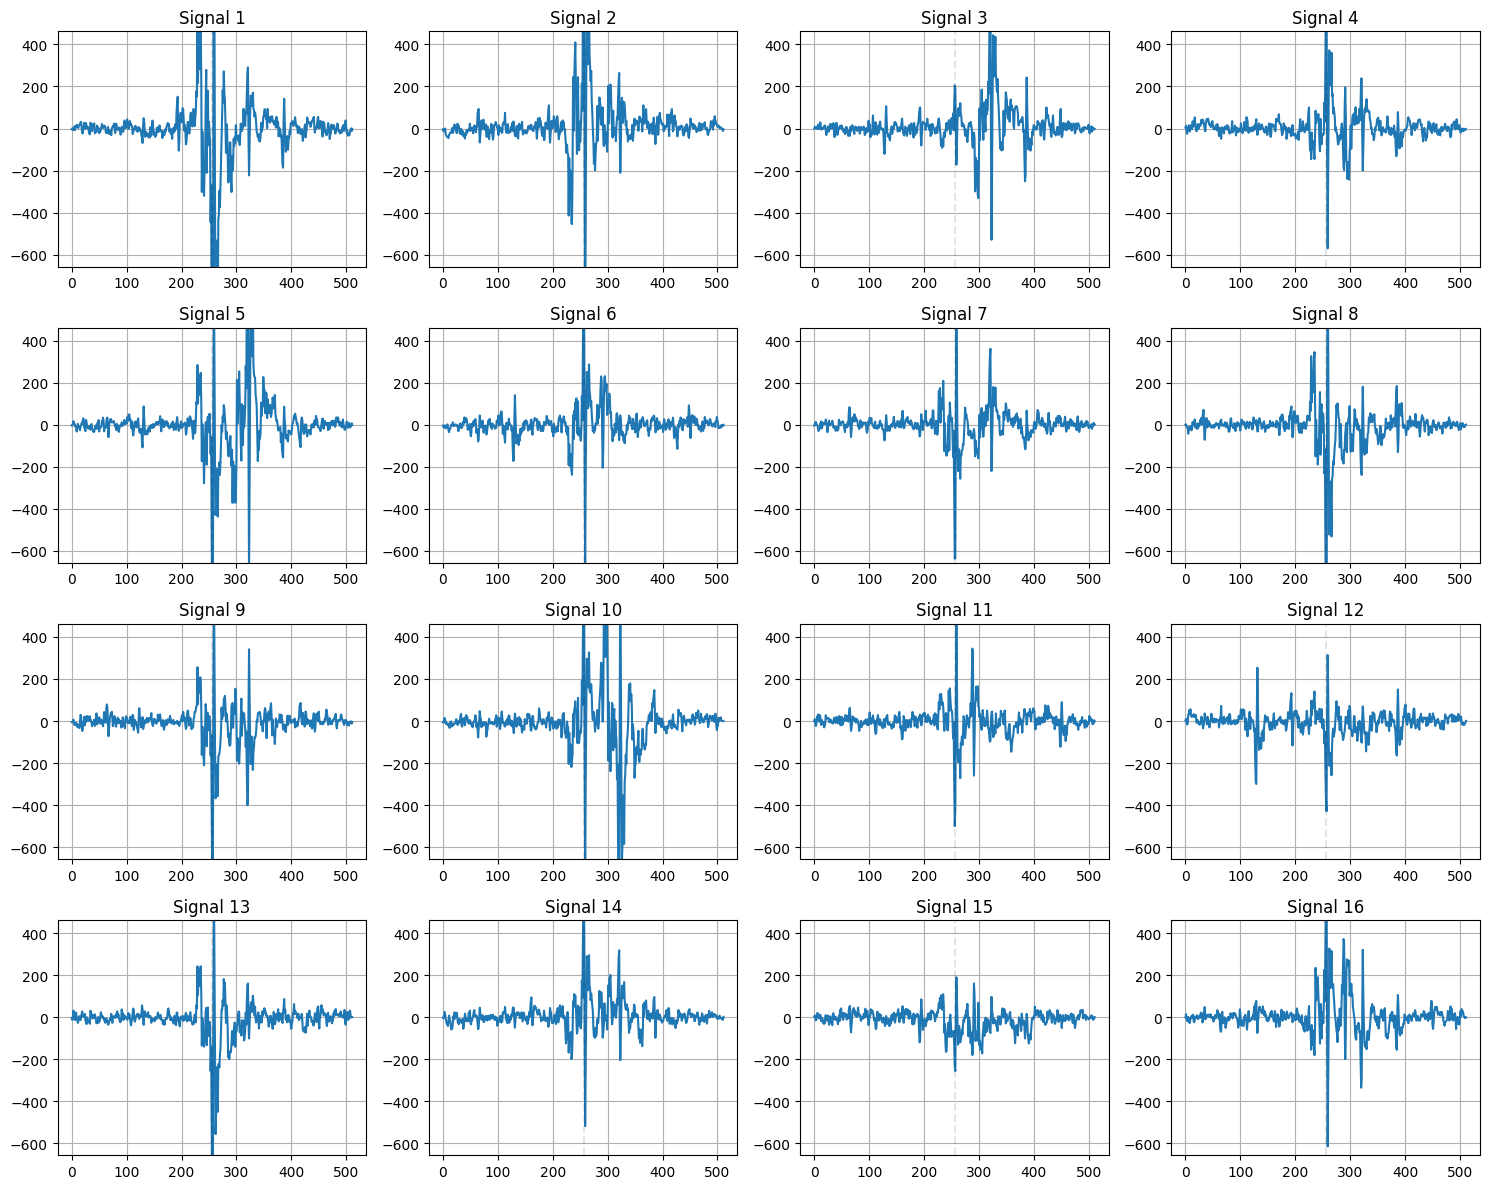

[7/20][0/188]	Loss_D: 0.9302	Loss_G: 4.1496	D(x): 0.1662	D(G(z)): 0.7796 / 0.8775
[7/20][50/188]	Loss_D: 0.8410	Loss_G: 4.0897	D(x): 0.1990	D(G(z)): 0.8507 / 0.8274
[7/20][100/188]	Loss_D: 0.4686	Loss_G: 2.2671	D(x): 0.1201	D(G(z)): 0.7594 / 0.7588
[7/20][150/188]	Loss_D: 0.9563	Loss_G: 1.4880	D(x): 0.1327	D(G(z)): 0.5245 / 0.6221


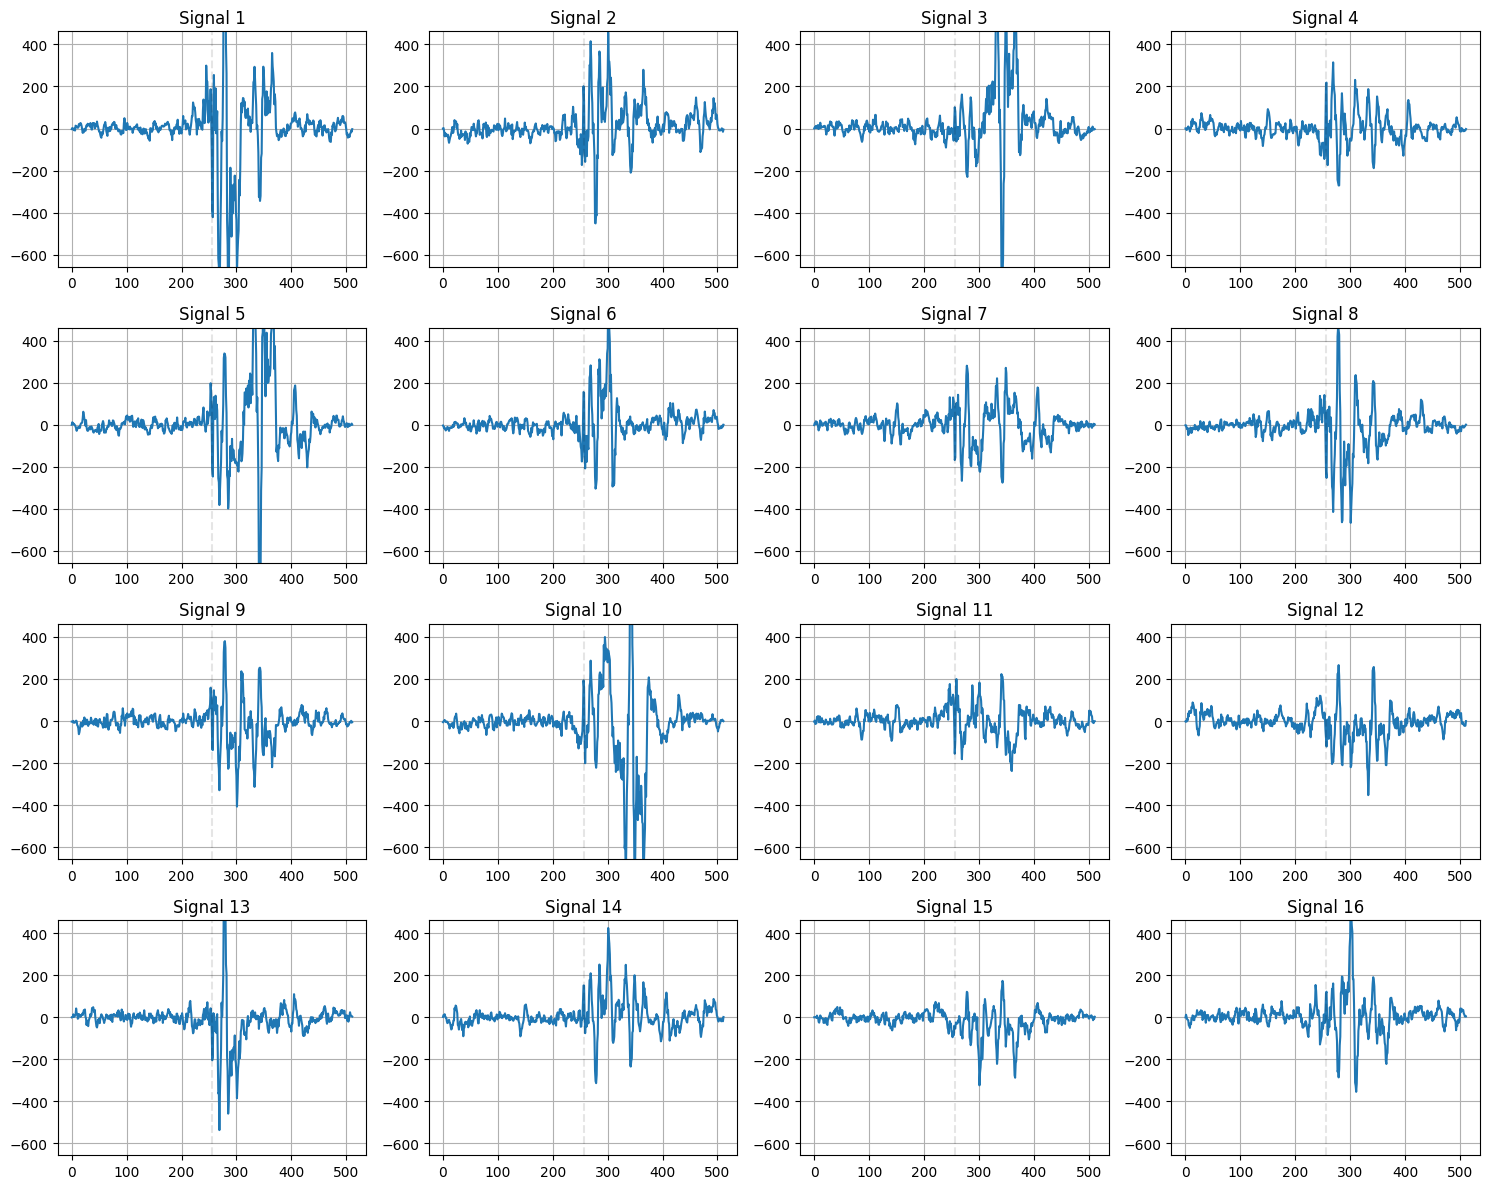

[8/20][0/188]	Loss_D: 1.1017	Loss_G: 1.4177	D(x): 0.3173	D(G(z)): 0.7770 / 0.6180
[8/20][50/188]	Loss_D: 0.6762	Loss_G: 2.6023	D(x): 0.1935	D(G(z)): 0.7812 / 0.7456
[8/20][100/188]	Loss_D: 1.2360	Loss_G: 2.3327	D(x): 0.2379	D(G(z)): 0.6494 / 0.7407
[8/20][150/188]	Loss_D: 0.9362	Loss_G: 2.7417	D(x): 0.1300	D(G(z)): 0.8241 / 0.8281


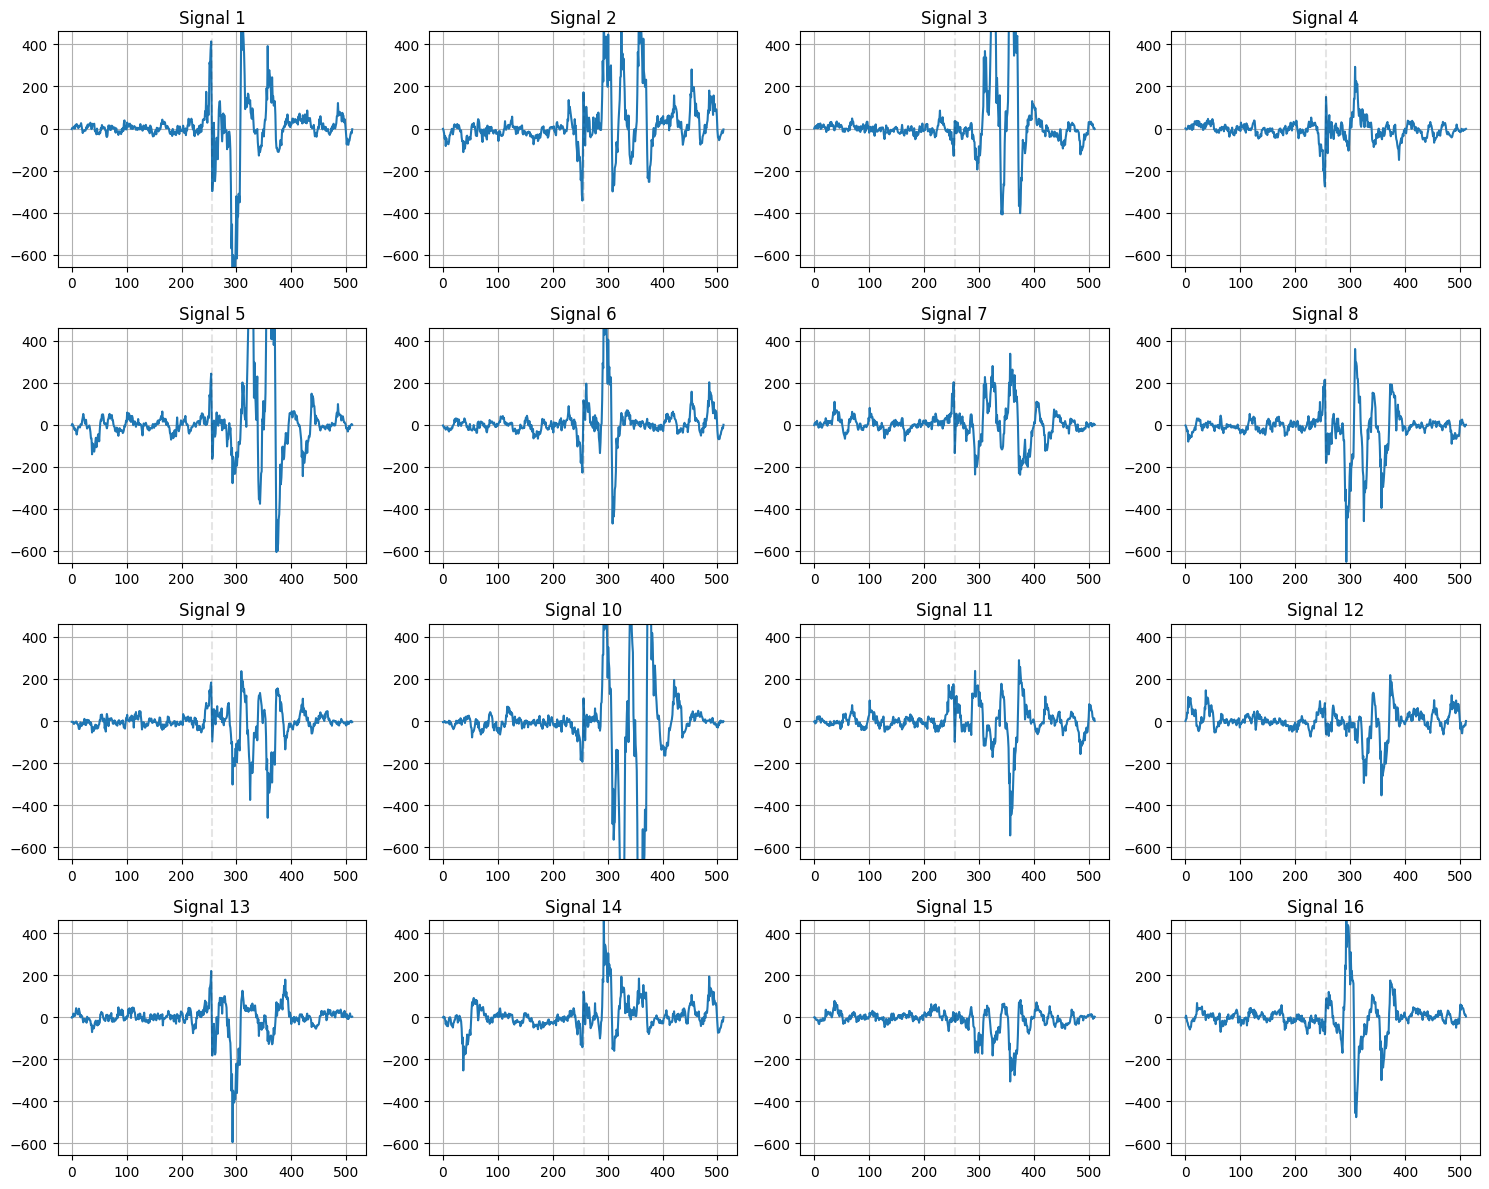

[9/20][0/188]	Loss_D: 1.2937	Loss_G: 2.1355	D(x): 0.2474	D(G(z)): 0.8373 / 0.7227
[9/20][50/188]	Loss_D: 0.9495	Loss_G: 2.3869	D(x): 0.2043	D(G(z)): 0.7844 / 0.7420
[9/20][100/188]	Loss_D: 0.9506	Loss_G: 2.5927	D(x): 0.1758	D(G(z)): 0.8478 / 0.7582
[9/20][150/188]	Loss_D: 0.7079	Loss_G: 2.7723	D(x): 0.2032	D(G(z)): 0.8332 / 0.7482


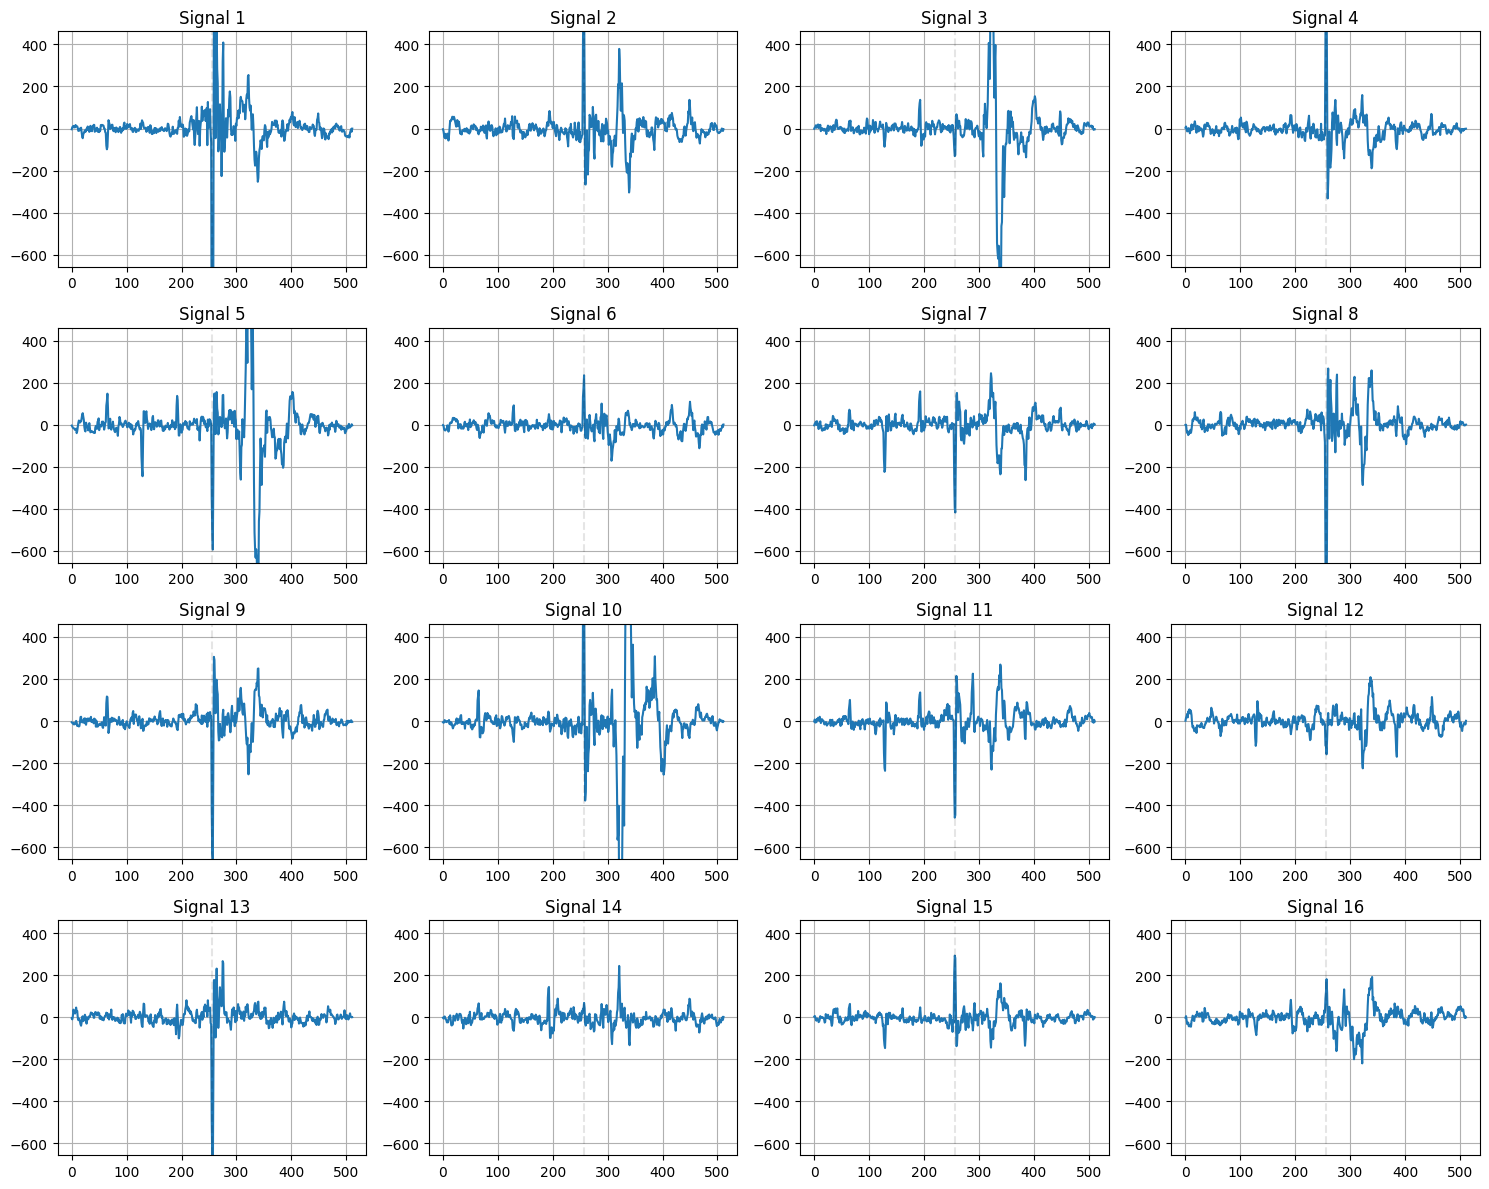

[10/20][0/188]	Loss_D: 0.9746	Loss_G: 3.5996	D(x): 0.1405	D(G(z)): 0.8206 / 0.8450
[10/20][50/188]	Loss_D: 0.7005	Loss_G: 2.3360	D(x): 0.1759	D(G(z)): 0.8059 / 0.7051
[10/20][100/188]	Loss_D: 0.7116	Loss_G: 1.8304	D(x): 0.0852	D(G(z)): 0.7416 / 0.6696
[10/20][150/188]	Loss_D: 0.6784	Loss_G: 7.2149	D(x): 0.1383	D(G(z)): 0.7120 / 0.8463


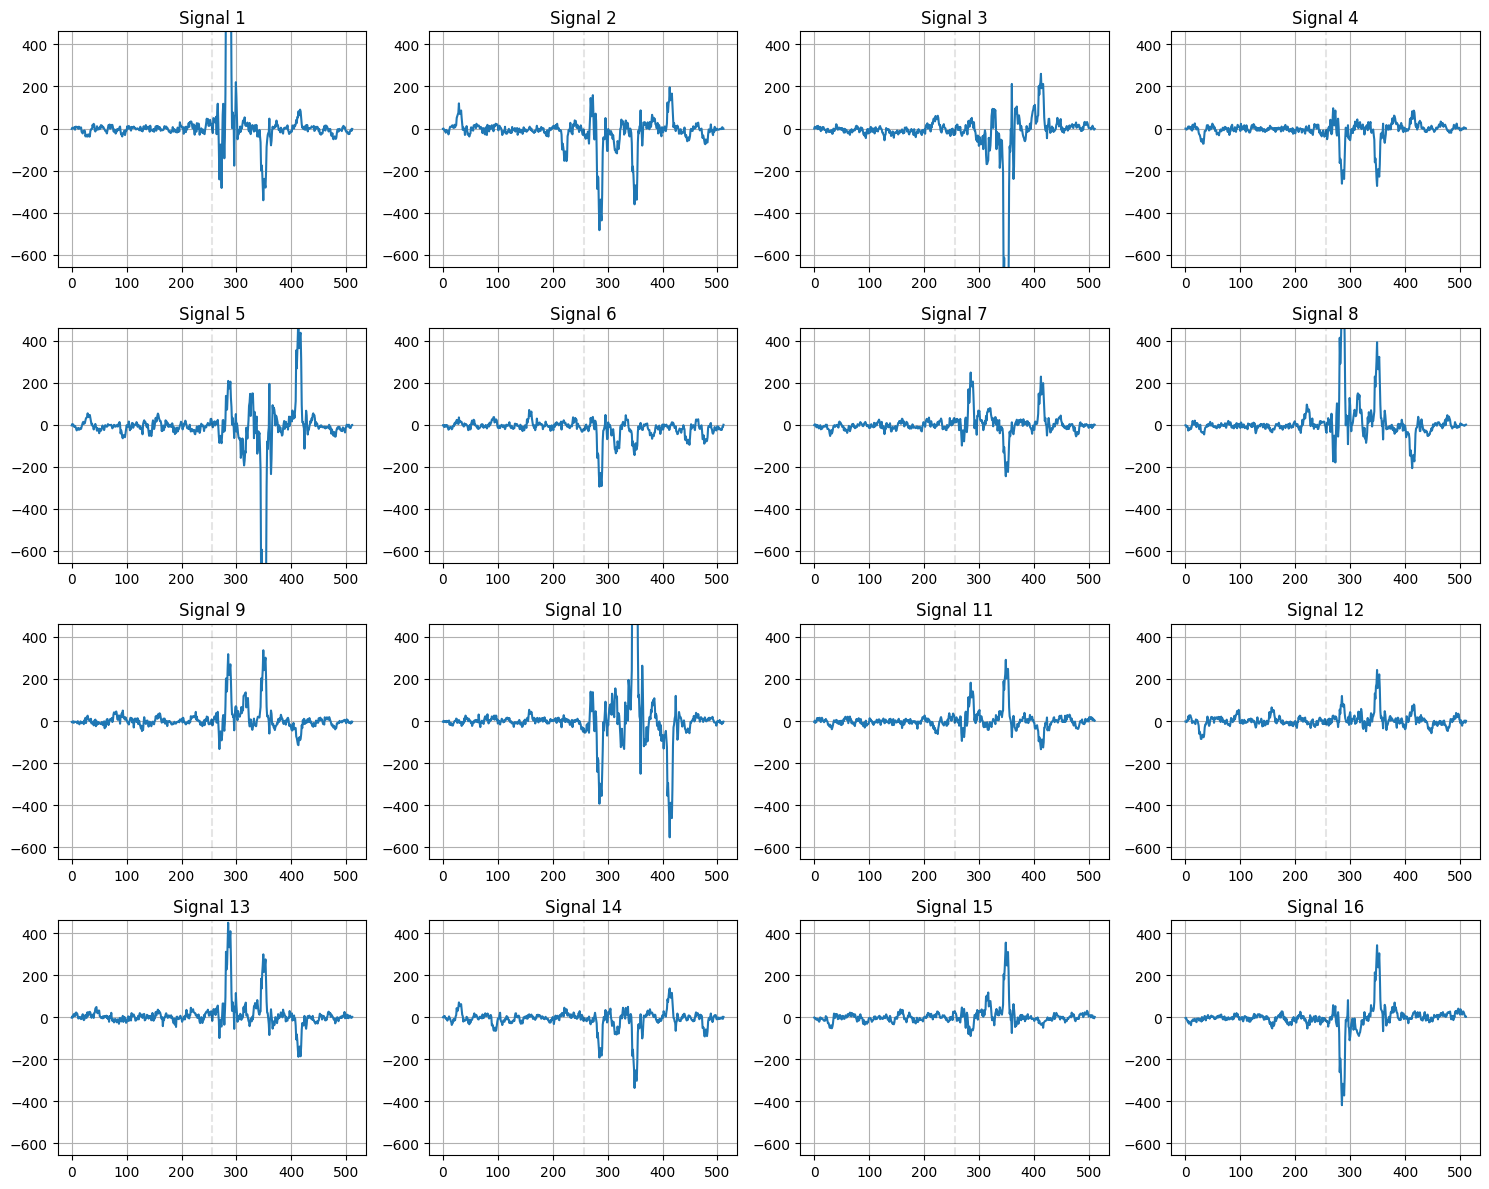

[11/20][0/188]	Loss_D: 0.7892	Loss_G: 2.9240	D(x): 0.1916	D(G(z)): 0.6841 / 0.8342
[11/20][50/188]	Loss_D: 0.8725	Loss_G: 2.8427	D(x): 0.1113	D(G(z)): 0.8321 / 0.8084
[11/20][100/188]	Loss_D: 0.7213	Loss_G: 2.4237	D(x): 0.1835	D(G(z)): 0.7950 / 0.8022
[11/20][150/188]	Loss_D: 1.0617	Loss_G: 2.7558	D(x): 0.1986	D(G(z)): 0.6272 / 0.8170


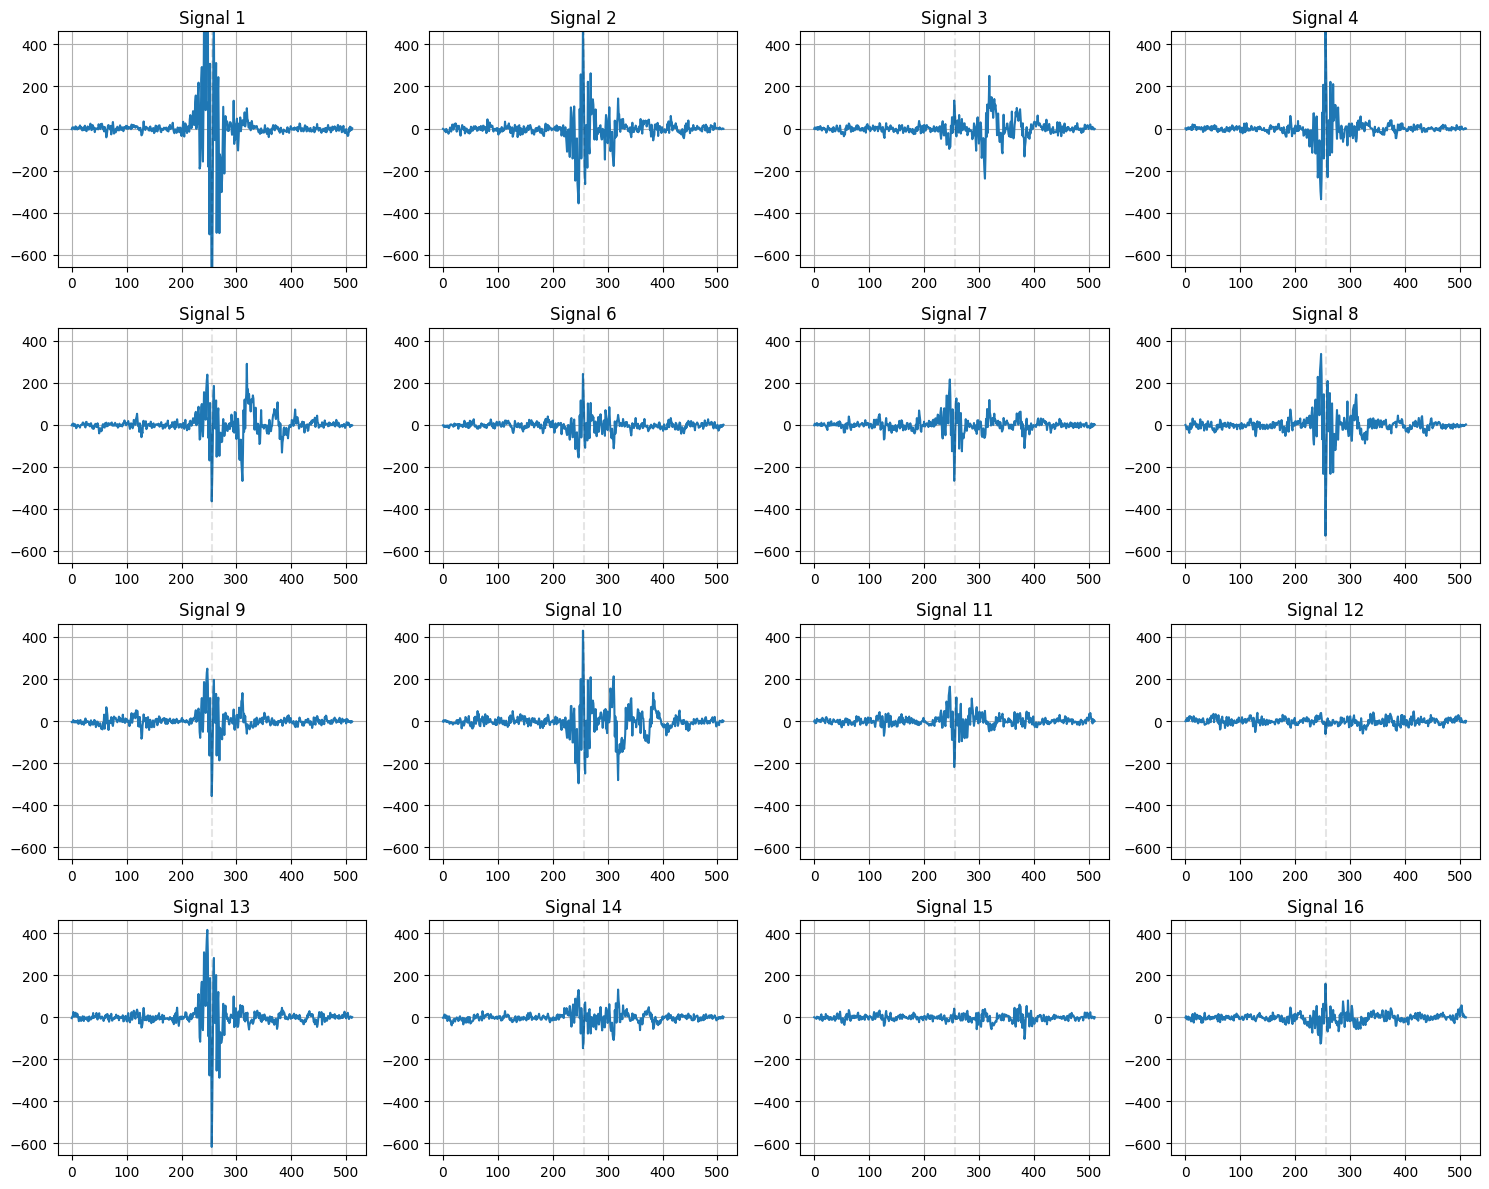

[12/20][0/188]	Loss_D: 0.9933	Loss_G: 3.6959	D(x): 0.2254	D(G(z)): 0.8204 / 0.8992
[12/20][50/188]	Loss_D: 0.6805	Loss_G: 2.6688	D(x): 0.0954	D(G(z)): 0.7163 / 0.7814
[12/20][100/188]	Loss_D: 1.0794	Loss_G: 2.8676	D(x): 0.1241	D(G(z)): 0.6939 / 0.7910
[12/20][150/188]	Loss_D: 1.1401	Loss_G: 2.8877	D(x): 0.2032	D(G(z)): 0.8126 / 0.8381


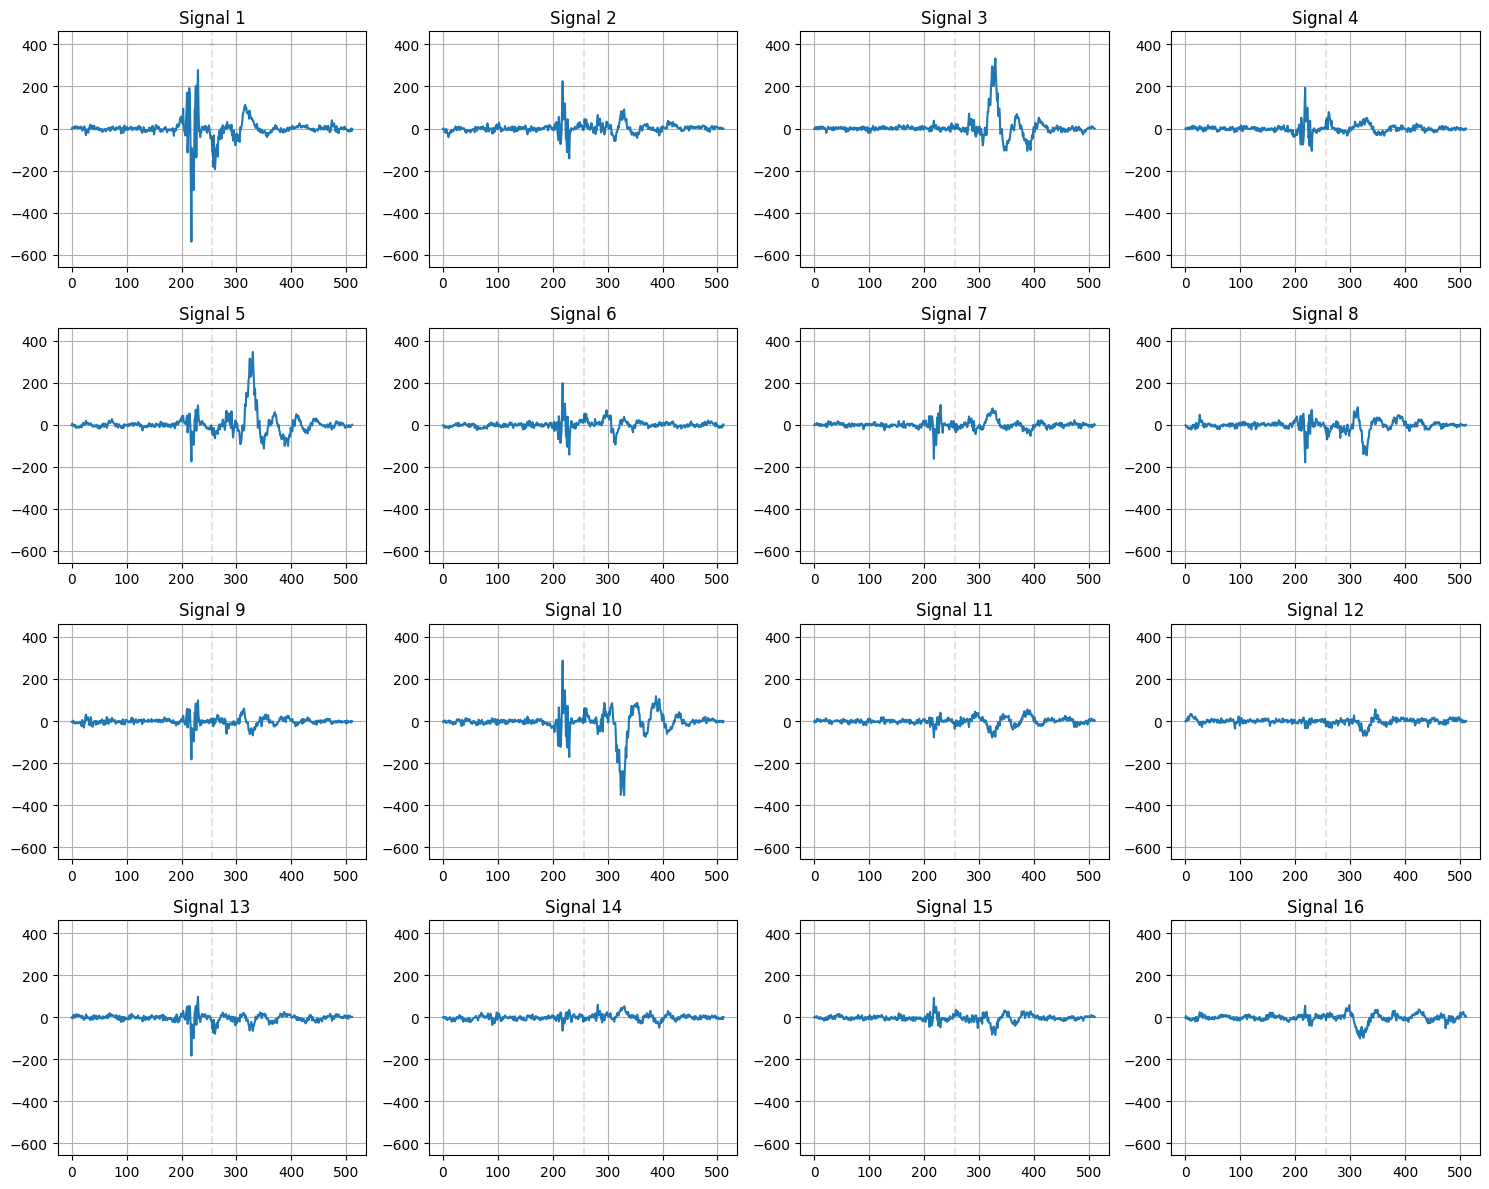

[13/20][0/188]	Loss_D: 0.7791	Loss_G: 2.1586	D(x): 0.1644	D(G(z)): 0.7522 / 0.7070
[13/20][50/188]	Loss_D: 0.8737	Loss_G: 2.3121	D(x): 0.1575	D(G(z)): 0.7206 / 0.7788
[13/20][100/188]	Loss_D: 0.8122	Loss_G: 2.6455	D(x): 0.1694	D(G(z)): 0.7057 / 0.7576
[13/20][150/188]	Loss_D: 0.9170	Loss_G: 2.5394	D(x): 0.1390	D(G(z)): 0.6910 / 0.7556


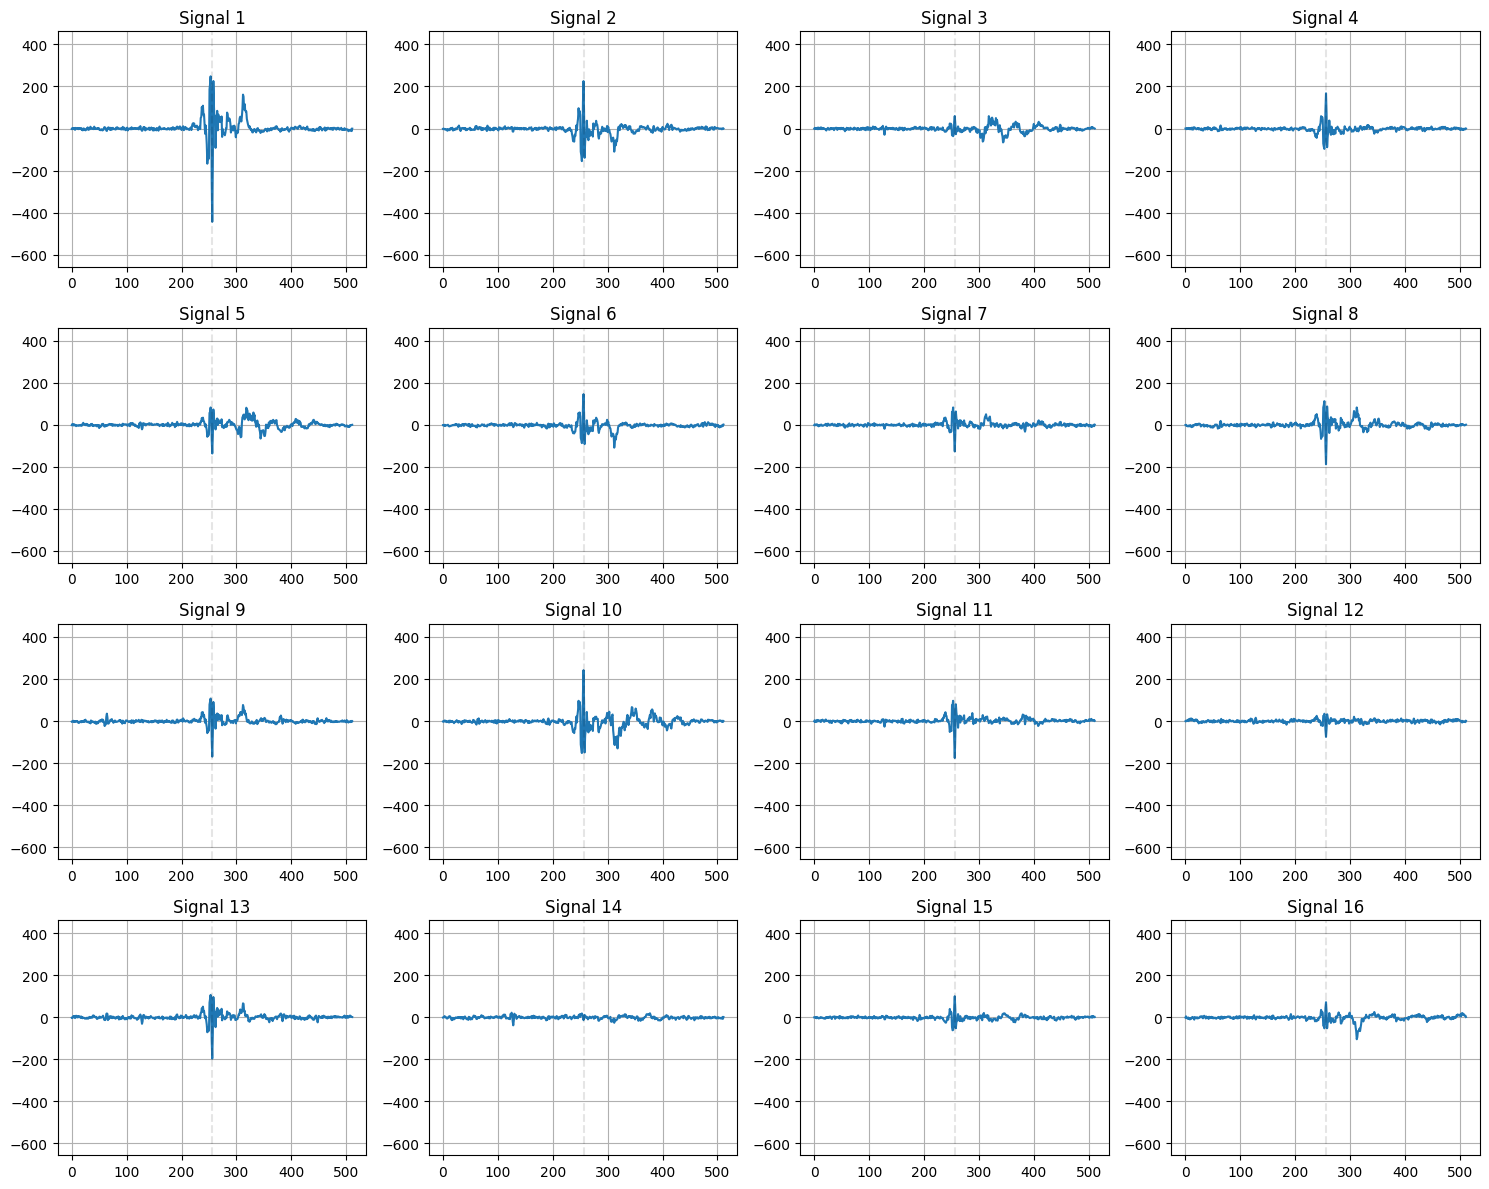

[14/20][0/188]	Loss_D: 0.5982	Loss_G: 2.8544	D(x): 0.1279	D(G(z)): 0.6324 / 0.8310
[14/20][50/188]	Loss_D: 1.2891	Loss_G: 2.4723	D(x): 0.1302	D(G(z)): 0.7528 / 0.7633
[14/20][100/188]	Loss_D: 0.5310	Loss_G: 2.2677	D(x): 0.1422	D(G(z)): 0.7685 / 0.7993
[14/20][150/188]	Loss_D: 0.9352	Loss_G: 3.2145	D(x): 0.0836	D(G(z)): 0.8190 / 0.8482


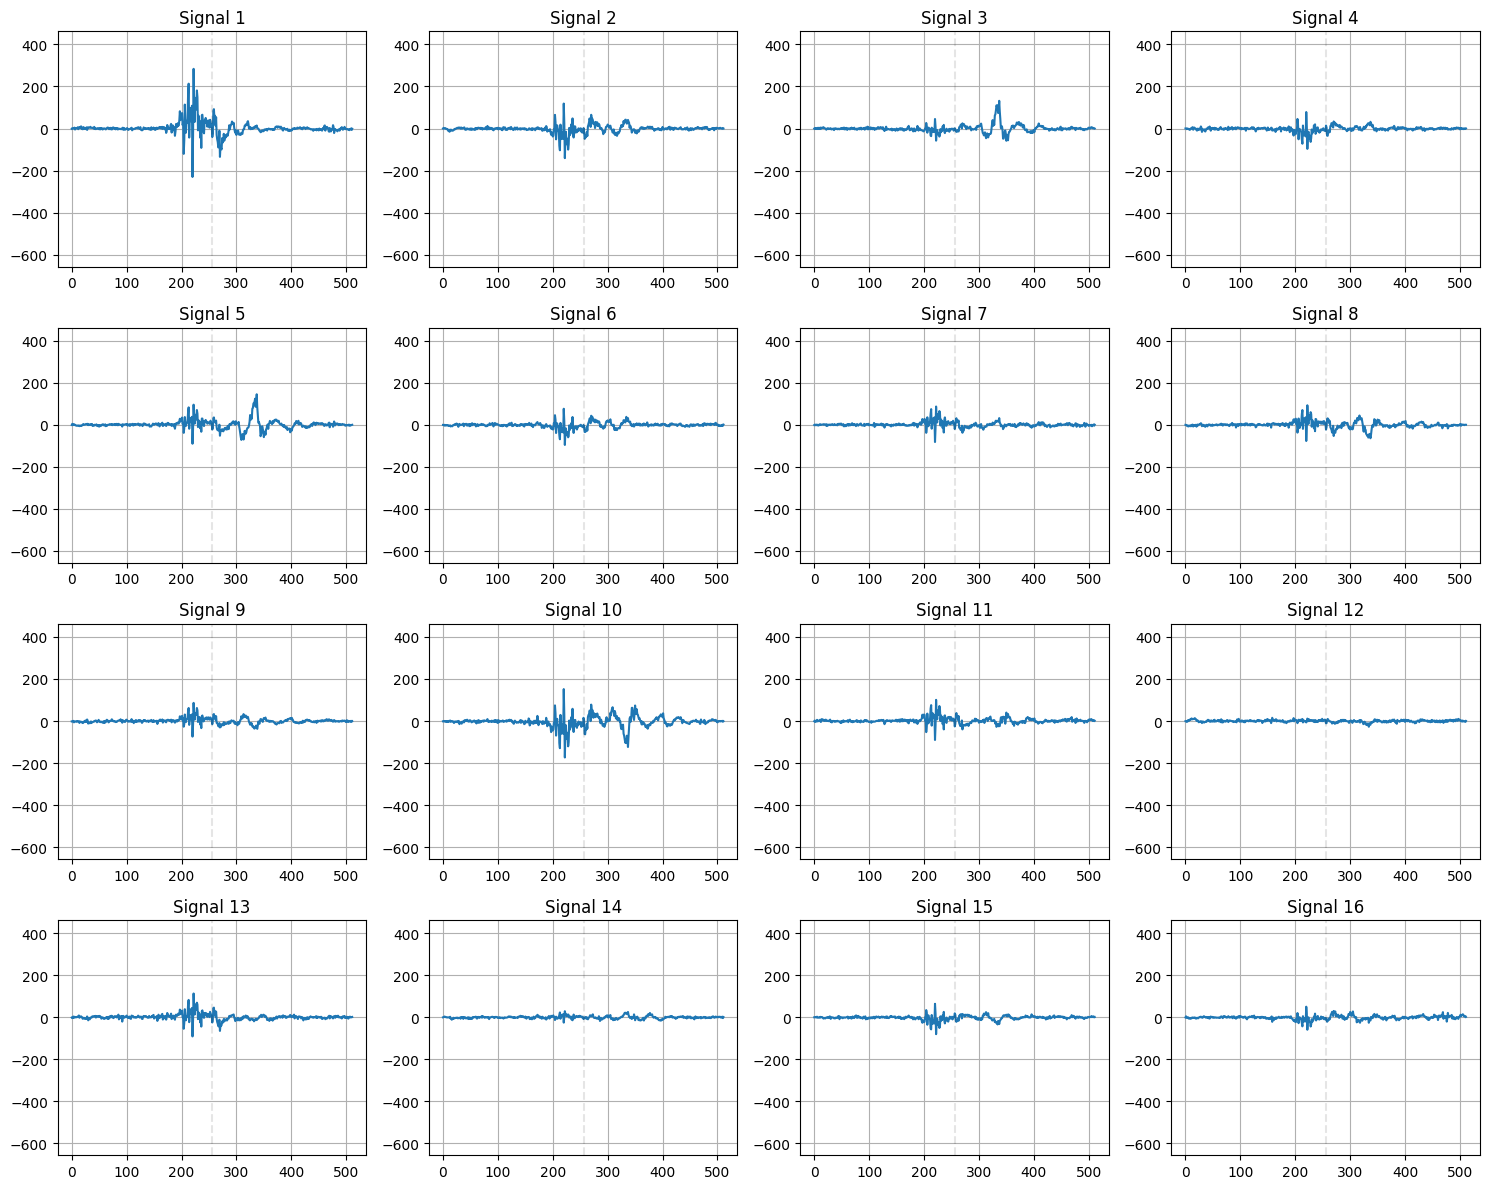

[15/20][0/188]	Loss_D: 0.8122	Loss_G: 3.3420	D(x): 0.1484	D(G(z)): 0.7740 / 0.7953
[15/20][50/188]	Loss_D: 0.9877	Loss_G: 2.6518	D(x): 0.1575	D(G(z)): 0.7056 / 0.7552
[15/20][100/188]	Loss_D: 0.5112	Loss_G: 1.8097	D(x): 0.0637	D(G(z)): 0.7316 / 0.7524
[15/20][150/188]	Loss_D: 0.6174	Loss_G: 2.1225	D(x): 0.1495	D(G(z)): 0.7512 / 0.7777


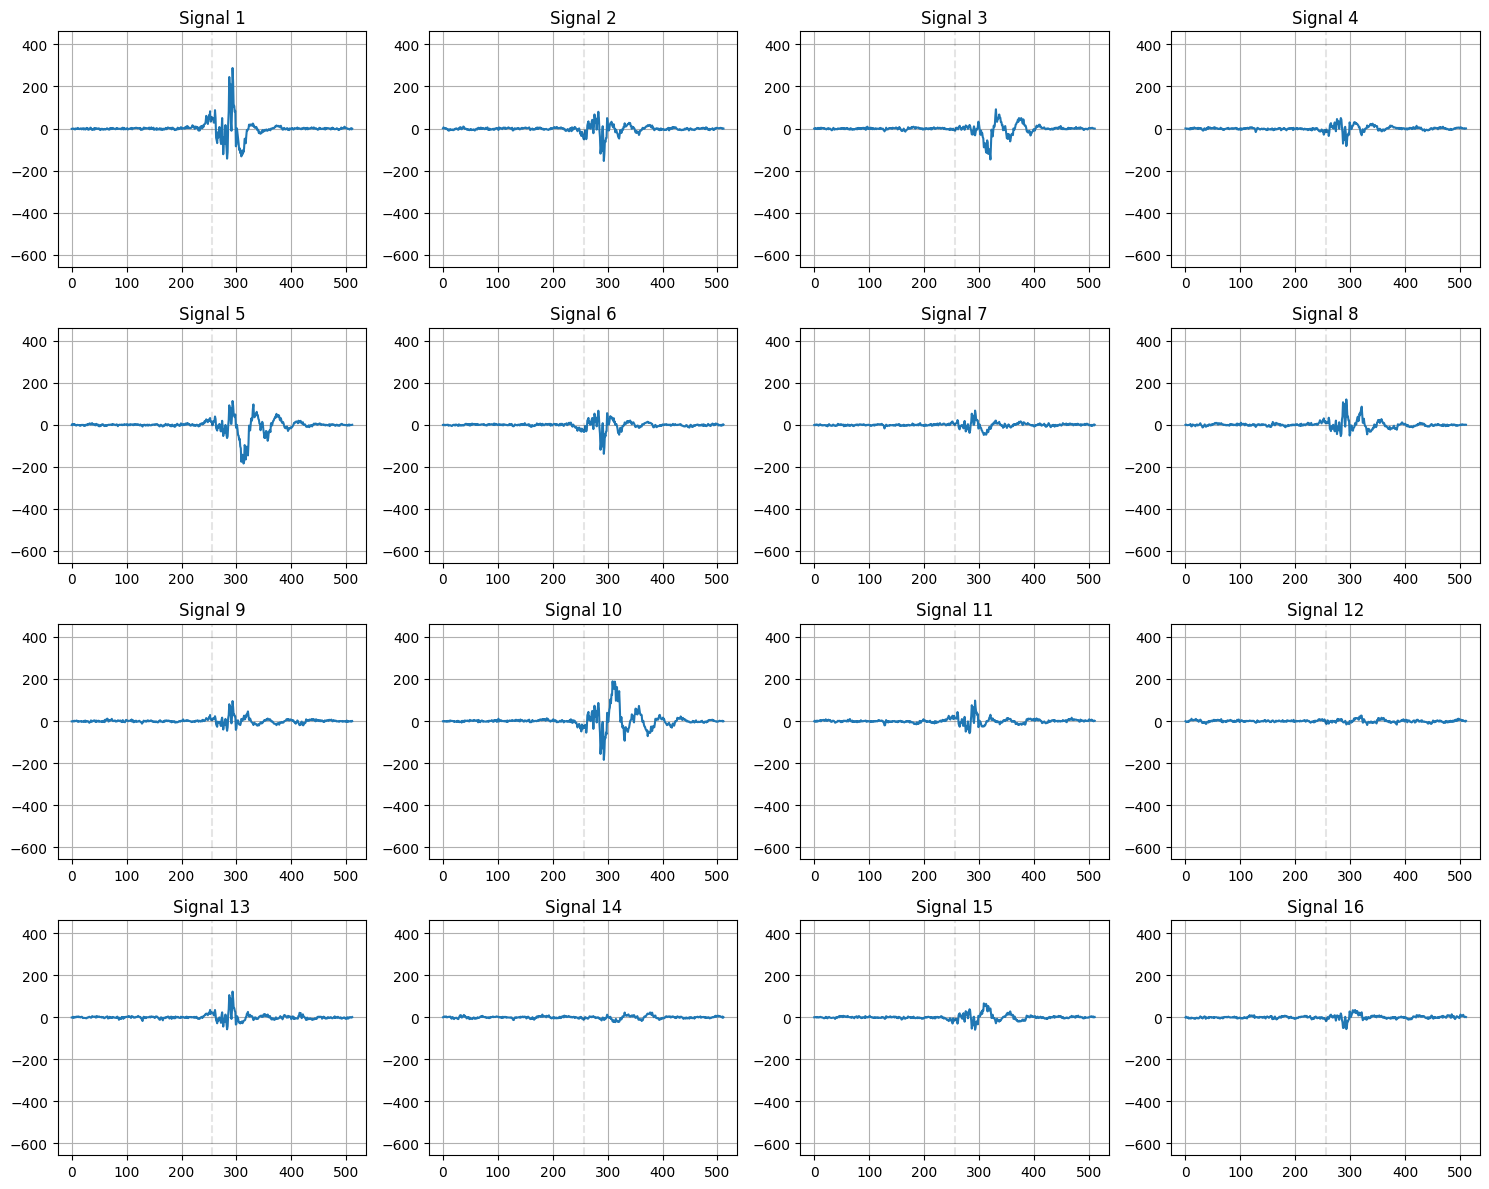

[16/20][0/188]	Loss_D: 0.6118	Loss_G: 3.0781	D(x): 0.1740	D(G(z)): 0.8894 / 0.7920
[16/20][50/188]	Loss_D: 0.8355	Loss_G: 2.4477	D(x): 0.1901	D(G(z)): 0.8372 / 0.7824
[16/20][100/188]	Loss_D: 0.7635	Loss_G: 1.6775	D(x): 0.1605	D(G(z)): 0.6451 / 0.6769
[16/20][150/188]	Loss_D: 0.9042	Loss_G: 5.0450	D(x): 0.1217	D(G(z)): 0.8395 / 0.9379


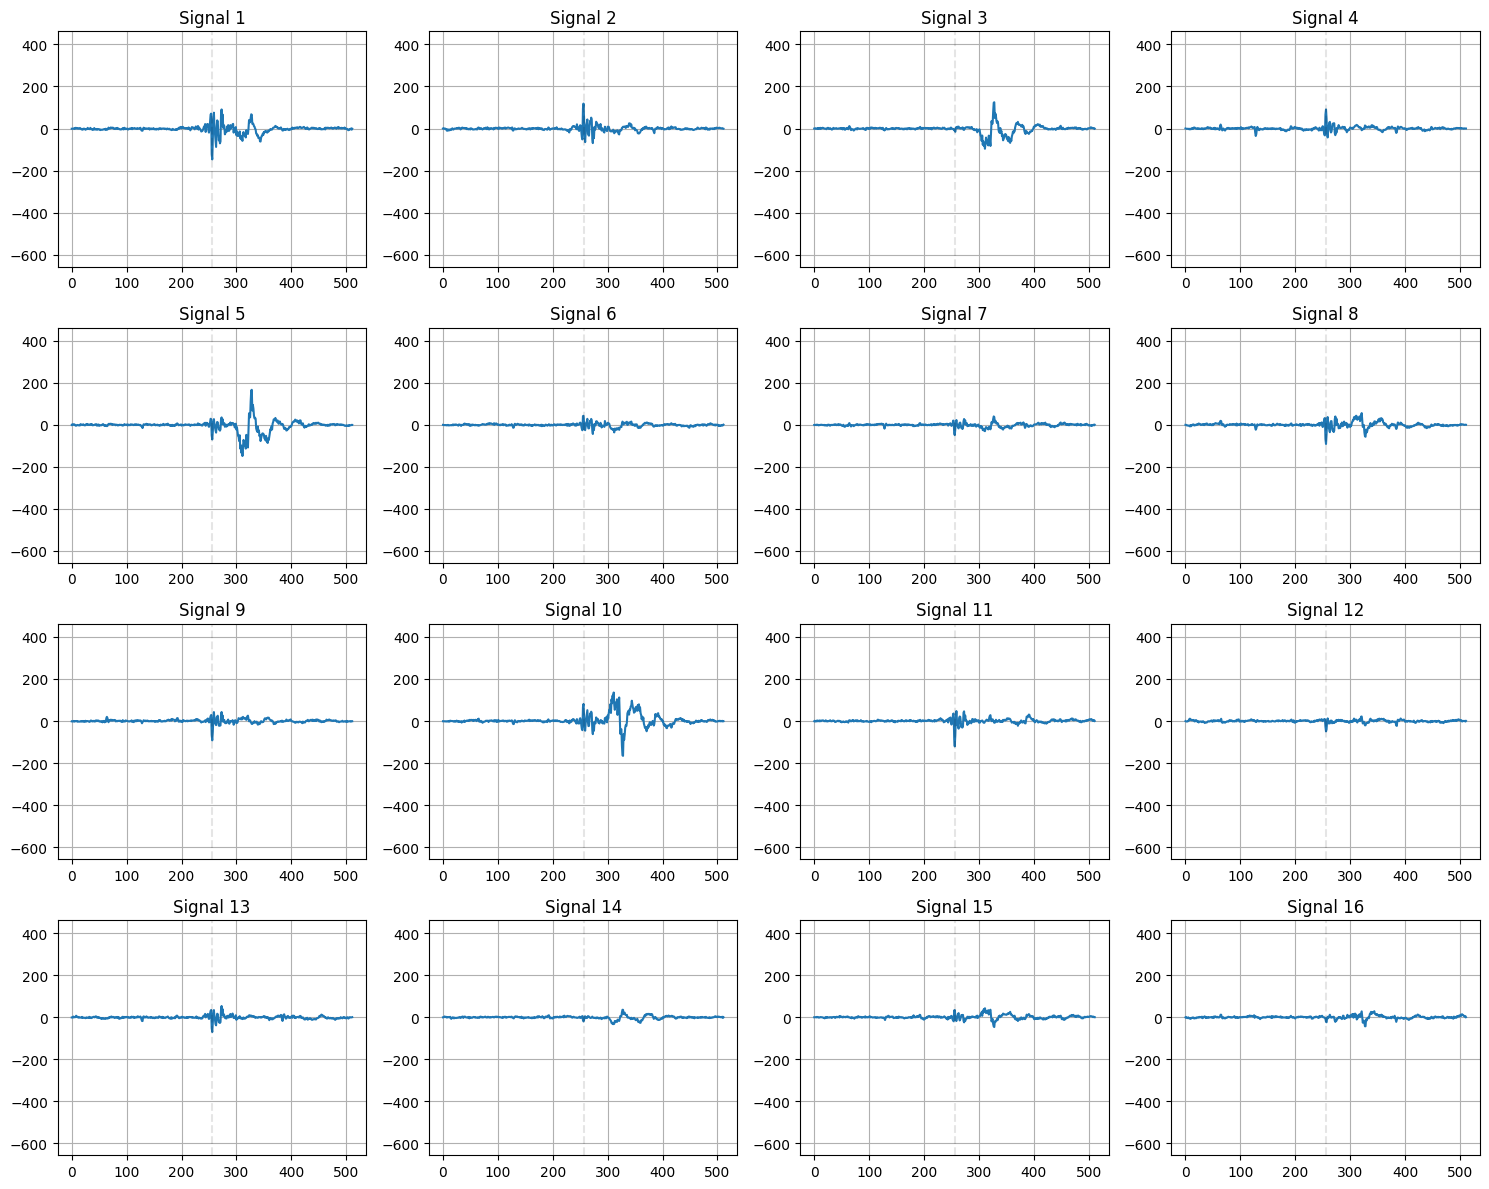

[17/20][0/188]	Loss_D: 0.9098	Loss_G: 3.2713	D(x): 0.1575	D(G(z)): 0.7741 / 0.8243
[17/20][50/188]	Loss_D: 0.8487	Loss_G: 2.4615	D(x): 0.0981	D(G(z)): 0.7507 / 0.8127
[17/20][100/188]	Loss_D: 0.7721	Loss_G: 2.2082	D(x): 0.1781	D(G(z)): 0.7950 / 0.7357
[17/20][150/188]	Loss_D: 0.5836	Loss_G: 2.6045	D(x): 0.0802	D(G(z)): 0.7707 / 0.7474


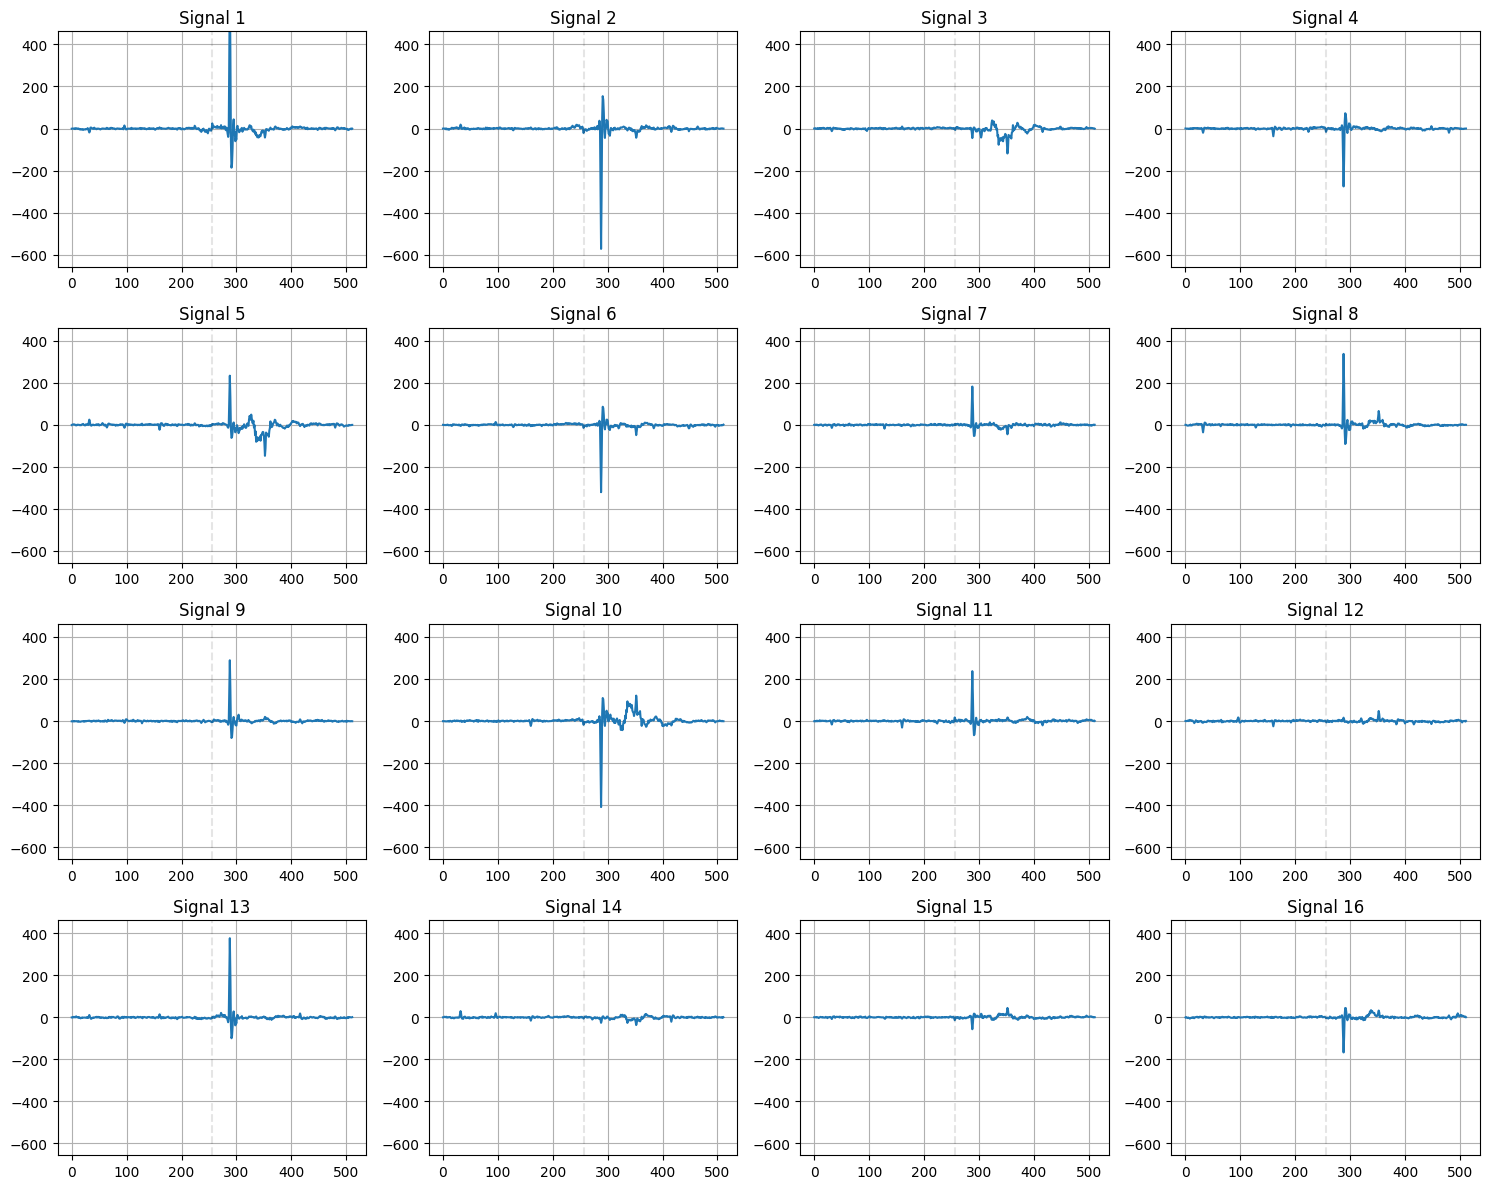

[18/20][0/188]	Loss_D: 0.4935	Loss_G: 3.3925	D(x): 0.1410	D(G(z)): 0.8192 / 0.7886
[18/20][50/188]	Loss_D: 0.7089	Loss_G: 2.9913	D(x): 0.1407	D(G(z)): 0.7569 / 0.8474
[18/20][100/188]	Loss_D: 0.7416	Loss_G: 2.5252	D(x): 0.1487	D(G(z)): 0.7512 / 0.7931
[18/20][150/188]	Loss_D: 0.9024	Loss_G: 2.7086	D(x): 0.1311	D(G(z)): 0.8257 / 0.7465


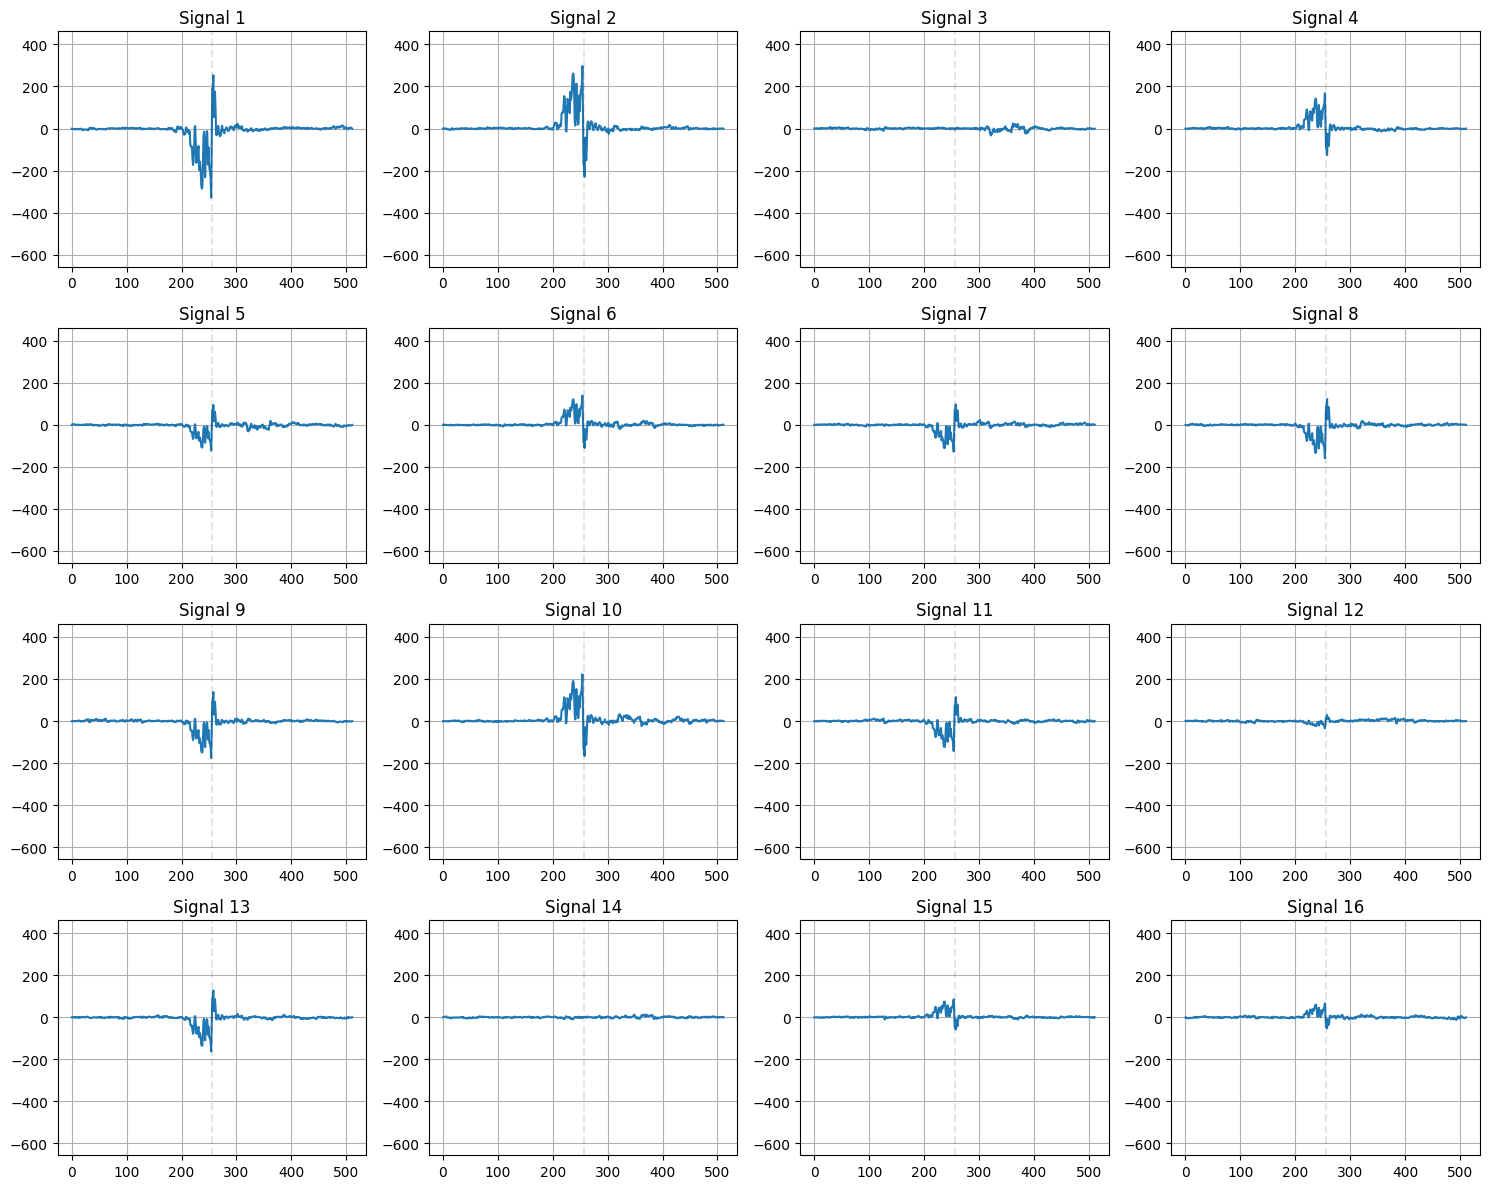

[19/20][0/188]	Loss_D: 0.7371	Loss_G: 2.8457	D(x): 0.1620	D(G(z)): 0.6346 / 0.8641
[19/20][50/188]	Loss_D: 1.2684	Loss_G: 2.1376	D(x): 0.1454	D(G(z)): 0.6704 / 0.7787
[19/20][100/188]	Loss_D: 0.8243	Loss_G: 2.3336	D(x): 0.1689	D(G(z)): 0.7316 / 0.7975
[19/20][150/188]	Loss_D: 0.4313	Loss_G: 1.9217	D(x): 0.0323	D(G(z)): 0.6802 / 0.7522


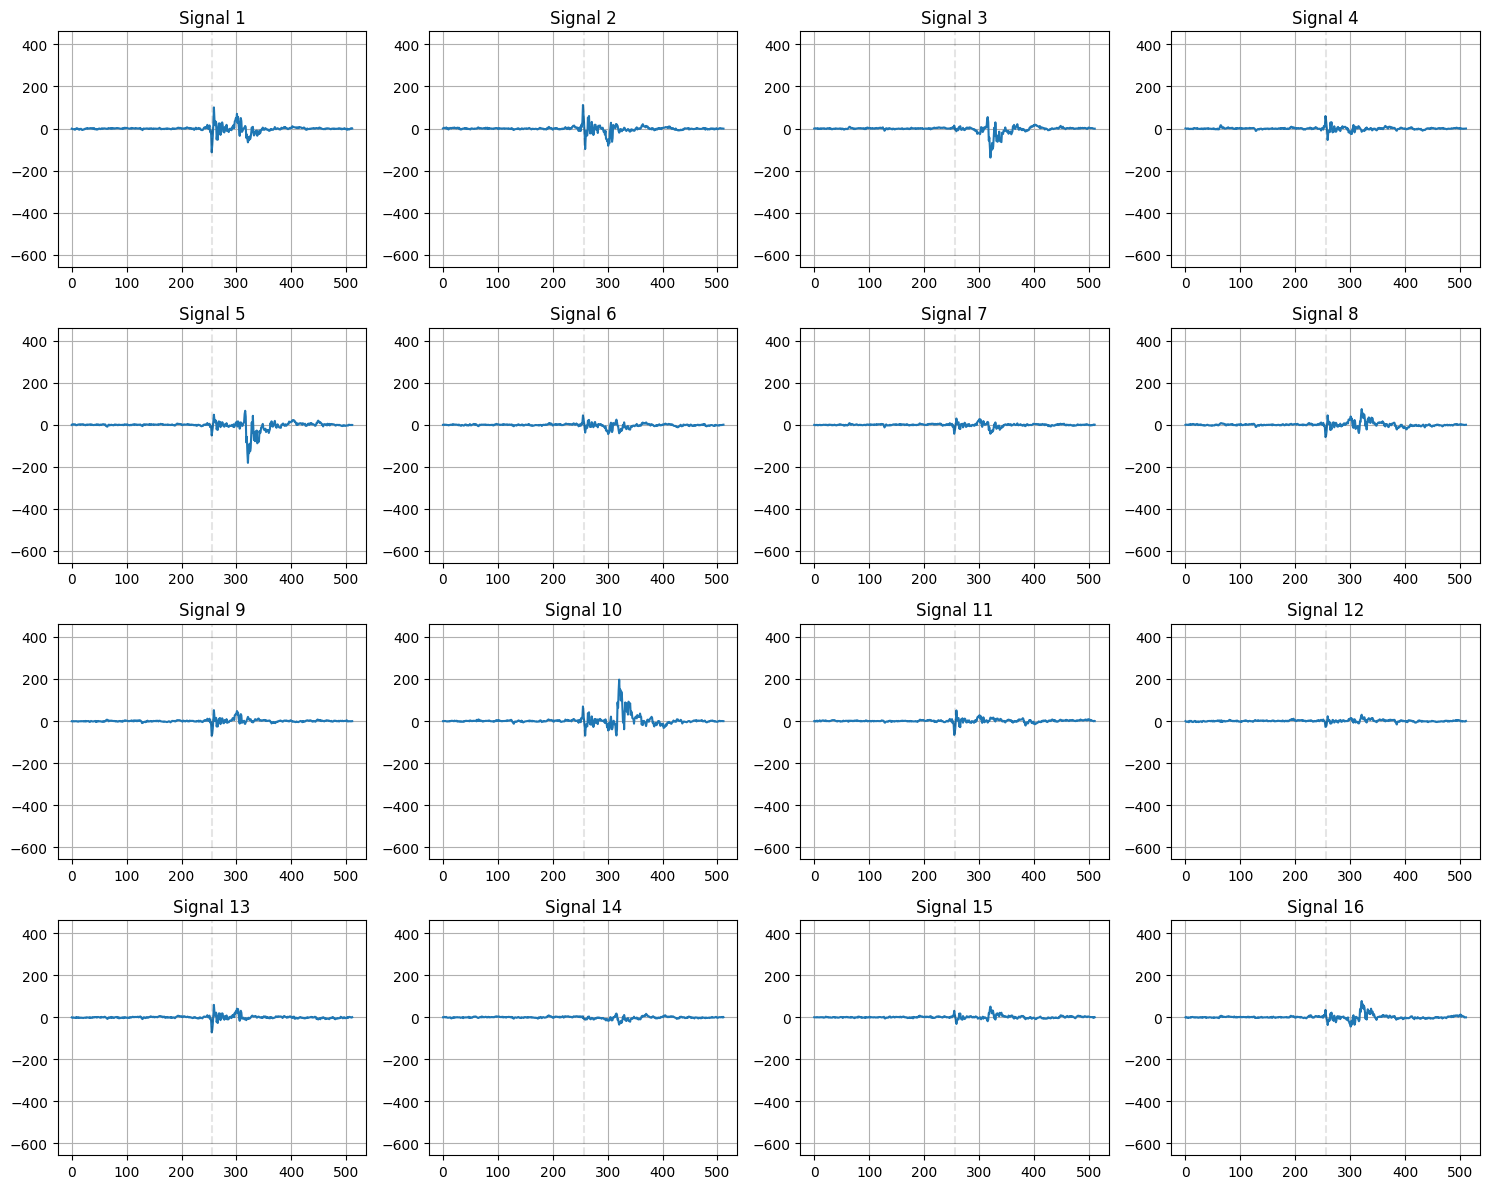

In [106]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 

    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

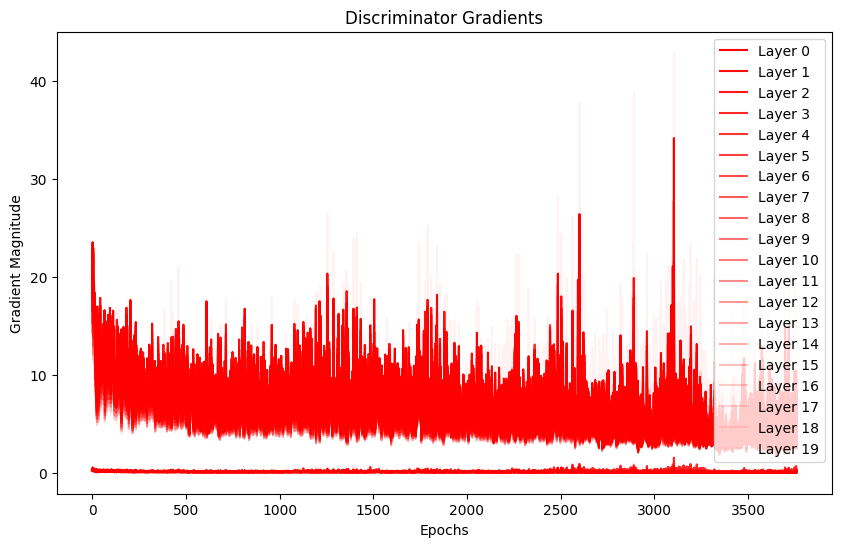

In [107]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

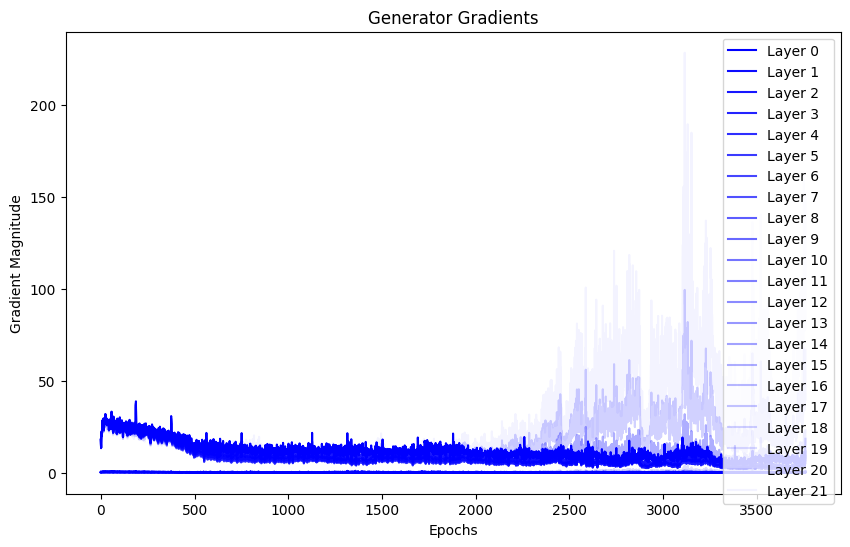

In [108]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

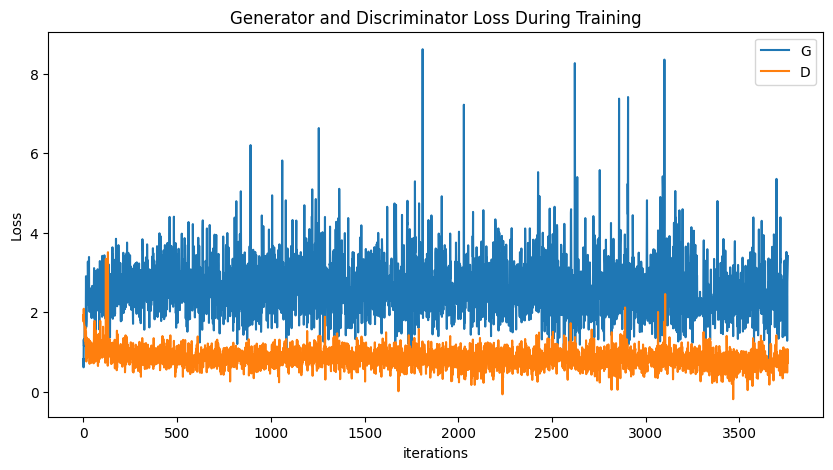

In [109]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


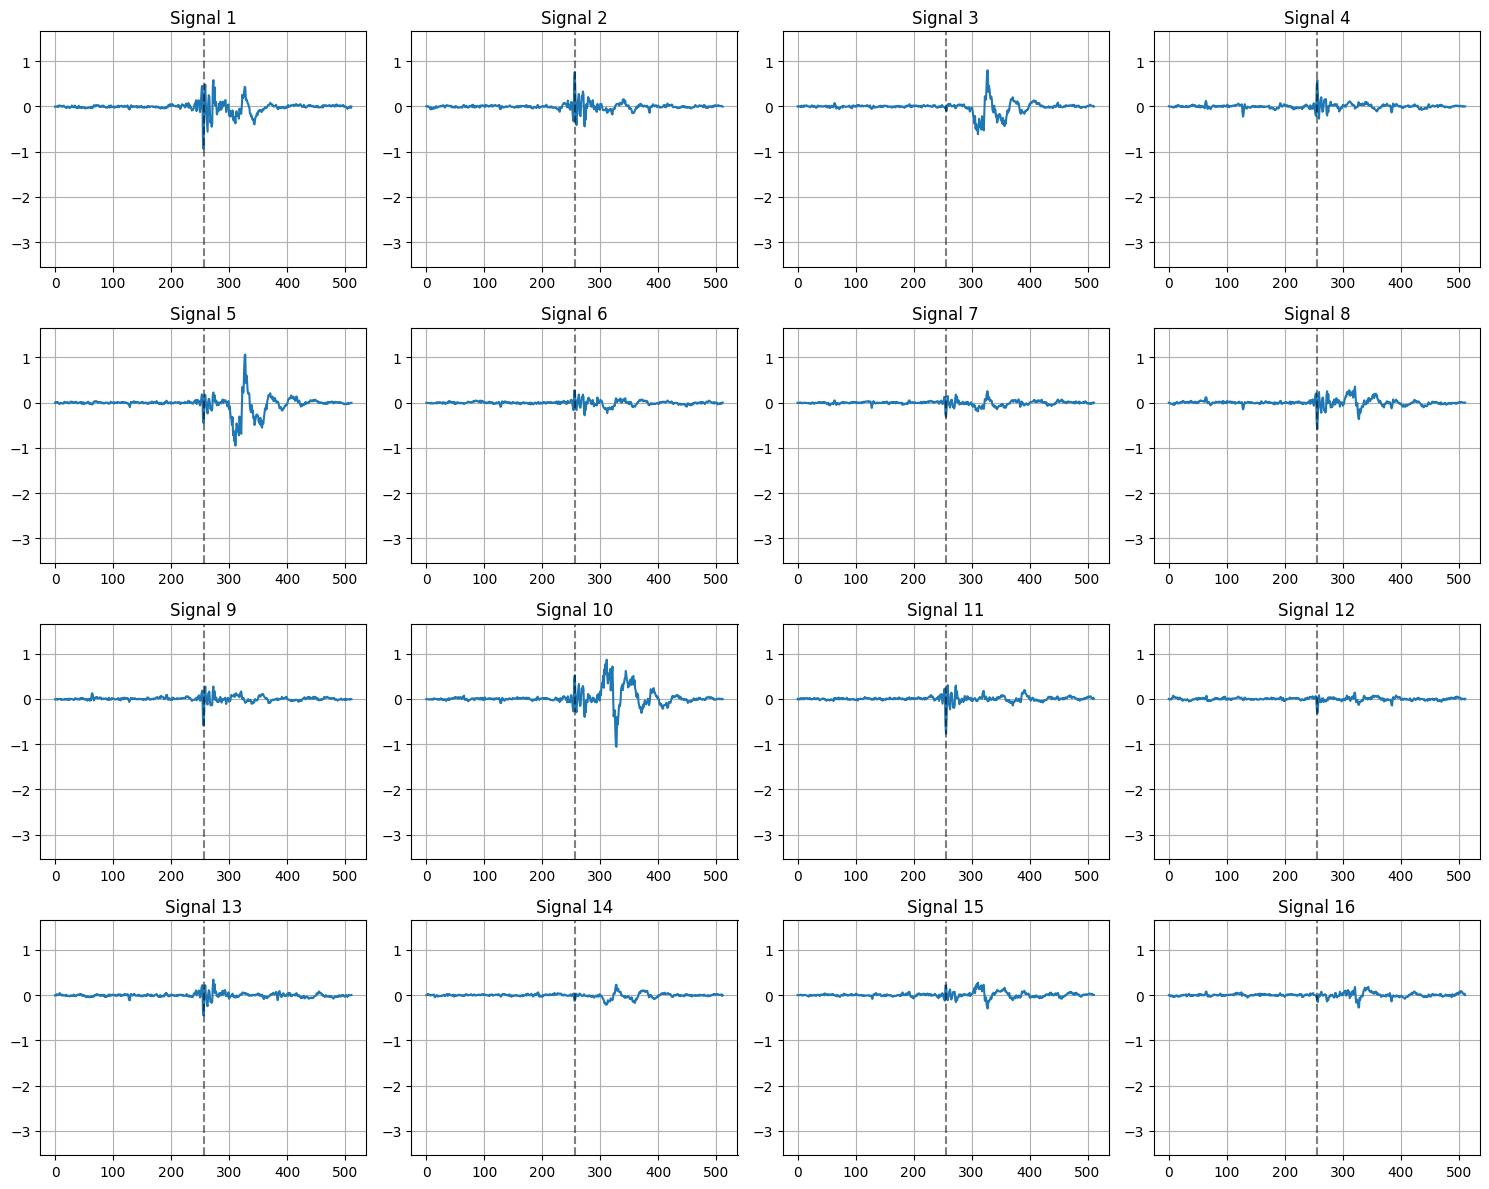

In [110]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [111]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [112]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
